## Introduction

### In this notebook we use [SRGAN](https://arxiv.org/abs/1609.04802) to perform Super Resolution on [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Training Data: 50K

Testing Data: 2K

### Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install opendatasets

ERROR: Operation cancelled by user


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset', data_dir='/content/drive/MyDrive')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Settings ⚙️

In [17]:
# number of epochs of training
n_epochs = 2
# name of the dataset
dataset_path = "/content/drive/MyDrive/celeba-dataset/img_align_celeba/img_align_celeba"
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.005
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 128
# high res. image width
hr_width = 128
# number of image channels
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

### Define Dataset Class

In [18]:
class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((64, 64), Image.BICUBIC),
                transforms.ToTensor(),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_width), Image.BICUBIC),
                transforms.ToTensor(),
            ]
        )
        self.files = files

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

### Get Train/Test Dataloaders

In [12]:
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_paths = train_paths[:50000]
test_paths = test_paths[:2000]
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

### Define Model Classes

In [22]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=2, padding=4), nn.Sigmoid())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Super Resolution GAN (SRGAN)

In [24]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [25]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *(1,16,16)))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *(1,16,16)))), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *(1,16,16)))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *(1,16,16)))), requires_grad=False)

        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            # img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            # save_image(img_grid, f"images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))

    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "/content/drive/MyDrive/celeba-dataset/saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "/content/drive/MyDrive/celeba-dataset/saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/3125 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/158 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/3125 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/158 [00:00<?, ?it/s]

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

#**Use The Deployed API (AWS Lambda)**

In [48]:
import requests
import json
import base64
from io import BytesIO

path = '/content/053204.jpg'

with open(path, "rb") as image_file:
  encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

url = "https://qywfdj2vce.execute-api.eu-north-1.amazonaws.com/SR_docker_lambda"

event = {"image": encoded_string}

In [56]:
%%time
response = requests.post(url, json=event)

CPU times: user 78.8 ms, sys: 4.11 ms, total: 82.9 ms
Wall time: 1.19 s


In [50]:
#Encoded image (base64)
response.content

b'{"output_image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACAAIADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD13tR2o7UvamSLTqSloAUU4daaKcKAENLQaMUCA/fFJ/yzHuaP4vzpcfKo96FsV0F/iNKaB1NBpiQdqbTu1JSAQU1qcKaaAIscUvYU7HFKFoEJS0uKXFAxBThQBTguaAGetO9KH2xoXchVHJLHAFUJ

In [51]:
image = response.json()["output_image"]

image = image[image.find(",")+1 : ]
dec = base64.b64decode(image + "===")

image = Image.open(BytesIO(dec))
image = image.convert("RGB")

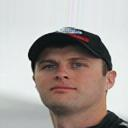

In [52]:
image

**Or**

In [64]:
!curl -X POST -H "Content-Type: application/json" -d '{"image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMgAlgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxPbg0Y/Kl4zS49KRVhB04o98cUAenBpcc+9AAACOtLjFFAI9OaAE4xkDml79OtKD3xSZ5z+tAC8A0DqaOSOP0pc7e1IBM5PK0vekBBPPFOAweetMA4x7UmRRkE4IyKXr34pALjpxxQTu5zRxjPJoDDpimAn1xQQM9qMc89KDjpQA7IxjgUmOeKTn8felByOvHpQAh69fpxS8egJoAx6YoI6Y4pAJ0OSKXrQc98GgdelABjHX8qdnjBAGKaRg89uwpe2aYxCccYBGaTBz0pcbjmjO3PPTtSEBGB/WgZ9aTvTjj8aAEIx2oIB6+lGfWkH4igBe/GKacelKefSgcj0oGJjnpS446c+1J60c0CAEZ6Uuc8f0pMkcUvpQMFwCR/KgHJ96ARnig4/H2oENI70pwO350ZyR2pT7mgAOMZxTSB6cUuO2aAOetAAUPtRg7uRRnpySaM/nQAmOKXHFGD+H1ozmgAAozx/iKUcY460EZ96AE47cUDn60Yx3oJ6UAHTgj6UpwccdaaQT1/Sl7UwADI5ozg4xxQB3ozmgBB9KX3xSYINHP50ALjHSk/CjmloAQccdqB17ClzxRjGKQAfwFIMZ5/CkNL2+lMAPX/wCtSZHel7daPfrQAcYqKVwowDyaezBASTVRiWOT1pAFJRS0AJRilooGJjvS0dqKBWD8KKKKBlrtnNKOlJ2xR2piF79KXOB70hooAM8cZpelIOOtL0NABjPajI7ikzg+lKeuD0oAXtwaOQc5pPbNLnHbk0AL9TQWz1H40n4ZNL/OgA4x1pR70nXmgg0AO75JH+NH0pOB0yaTPX2pALuONvFGTSdf/rUvGc96ADBJ7ZoB7dT6Uc+31pD+VACj3xRnjB4o7jFJ+dAC9D2peBz2po5GAaXng0AA6+9BHFGD26UbgBjFAB+Ao45zij8OKM56/pQMB19cUHI/Gjpkj06UnbmgBeNtJnn6U7oOQTSfWgA9M0pHHNIfbpQeOT+VAhD646UAdOcGgt3HFJg+uKBgc55oHXJ5FHTgc+9GaAHD1Oc03qeKX0I5FKcetACHI/8Ar0uMUzNOyT1/lQIB15pDx70EfjRz3oACc9qPWlJ7dqafwoAXOKUEUmKOMAUDF54owPoKMc9aQ0xDsE8c0mfeg9Bmkzgd6QC8CjNJnjnmjI70AGelLxnIo6npSACgA6+ho6c5o4zR1PvQAUe1Bye9Hb2pgB7UmeeKPej8KADvS5oPPIpOaAF4470DnjoKBwaimkx8g6nrQBFK+58A8Co6KWkAUUUUAA60UUUAFLRRQMKKKKBFnGe9KOCR+tIOvek+lMBw5yKUdPQimn6ig4J4FADsjJoxnnNIR8vejtSAXgnHNIOaM8elKOlAACBilzn6UmeaP1oAM0o46UCg89OKAF5xkUAlTyKQZ+tLgY70DDOOmRRznFHSj8aYg4FHU57Uh70pGRmkMMn3xQeOp69BSc0oIP1piAc0e1APIoOB2pDA5BxwaBkmkx74NLxQIXp3pOlGcGlByM8GgYZBBzRnHbH9aM4NJnHfNAhQ2O1A/wAikJoz3oGL045oB+brQDj15o6HHWgBSAab3460Drgmk6HAoAAc8kmjr60d+P1oA7UAGOKBkUE5pMjjFACjJ5pM4NA4NLgZ55oAMgjFLnmkz9cUfxcUCAYzxQT7UHtmkANAC5GPSj+XvRmkJoAXvjNB6UnHYUucAZpgFHXrSEkmlPTAFIAzSHGaUmk6c55oAXA70YBFBPHNGc0AJn3oBzRz2oOaADGOhFBoHA5NGaAAHHajOKTv1o4HNMBQMmk6nijtQOfp60AL6UUA80MwUFj0oAR3CJnvVQ5JzSu5c5P5U2kAUtFAoAKKMZpaBhRRQKACiiigAopaKQix9KM+lIM0oHWqABjHvRnFHv1o49MUAL25pMDGaOaXOKBi9qO2cmkOfyo6ntSAMe+aUcGk7UY/CgB2eeDR9TzSD8valyMdKADkH0FLnJxn86T/ADig470AFH50mcjFL1HtQAg7YPNKf96k4+tKe/X8KAFB7A0n4GjJxx3pKAFz2oGQcUcEcA0duOvegA75pQffk0maB+lAB14NLxnBpMj06d6cPoKBDfbmlPBBxR0bOMqadJGyor44bOD9KB2G+5oPQdKkiiElvPKXC+WVUA9yahAIBBPQ96AHZPPNBJ6DFJ04J5pCfxoAXkn/ABpCcnpS80d6AF5CmkzzTXztJ70oO4A460AHfpzRnFBzmjOOeKBBz3o6UZ9aXPGMfjQMRgDzQOBR7cUUAAPH+NKRnmk7+9AyKBB0GKPWj3o7igYd6Aexo7mj1FABigfWjNAPtQIARz60pBpvTmg8igBwHqaOBTcelH060AL3ozxRxSUABozj6UA4FHU0AJ1pcYHNGPxozQAHNH60d6M4pgL7YNQTPuO3sKfK+1cdzVakAYpaSigYUtFFABS96SloABRRRQAUtIKWgANFFFILE/0pec4PNJ3pQRnvVAH0o+tHrR1PFIBeaOR1pMc+tHI5piFx+FL9eaQHnnrS/WgYdB3o70h6noTR7UhC0UUo56UDAe3U0fhQDzRnnHagQA8+lJ+NKaQ0DFo49DSDA/8A1UZoAMYFLzSHHak/GgB3J70nI6Gjd05NOEYlJETFmAzgjB/D1oAZ3A9aQnBx0IoI+Q+1M35696AJUbeP9r+dNJwysSPQ/SkjXkEOFPucVK9u7DlV5/iyMfnQA5gijaWxuHWnPNJBBAynJRmIJGR+VI1spG4Sx4A2lQ2aRpUFk8TDLEfIQeOvP6UDJoJI2tjFcDaZCX3qPut2OKlNi8+k/b4SsgjOJlA+7zj/AA/OqCjOARzWzp18NGnhljffBPEVuYj905JBH5AGi4jGxyDxzTdp3ZBGc8Vd1SK3S8L2kmY5BkqeqH09x6H0qpswooGMdsrwe/5U9RkAkVHjEuQfepAMBSOQf0oEIWBU88+lNB2pmmyDB3CnFAcHt2oAcmSMnvRigD3NGeOtABjH0peMZzmmtnoDyaBgDFADuOuaOc0lLnkd/egAJ9KKOvFAAoEHbrSGlzgUnagYd6U/WkBo+lAB2o+lL29aMc0CF7Ug/wAig8nNAoAM9sUmefSjGTR3oAWkxx6+9BoB4oAQ9KPrR0peRQAmcUp6c0nWg4oAOaGYKCaXPvVaSQu3HSgBGYs2abRRQMKWikFAC0CiigAFLSUtABRRR2oAWiiigAooooAn6ml/Ck/Cl/CmAdsUHkUetA6UgADFHpml/wA80YoEFHXvSduaUd6Bhnn6UUUZJ70CFx3ozScgUueRQMXjkikxx1oz6Un64oEKMA0AgnPNGOmcUnagBSOTimk+/wCdKeOlMYkUDFz609GXJBFQhsnFSpG7n92rMfQCgY6RcKGB+U1WJw3X3rRFvK0G5YcOvDZxz71Tmt5IuWjdR7rQA6Wc3CKSn70cMw/iHqfeoQv8THA9qerYVcdzUkcZlTylHzEHb7kc4pAI4ASNipVHBAJ7EUuHVtjnB6Vq3tqqeEdLfJ3tK8hGOArcf0FZiRvKF3Anbxn2psBYwXV4wCerZHY1XfqB6cV0MP8AYlpbq1zZ3sjMvVpwuT/ujt9TVO4v9NZcQ6cyjtucNSugKKzDIW4jZlUYAzjFT2919lcSQhZEI+ZJR8rDuKjN2iy7hH5bdmIzULFkUYHy9QR2oA05otOvmEtqzQ9N8TtkofY91qtLYSwxbwUkjzgsjZ2/UdRTrK2jv5TELiO1uxzG0hwkh9M9j9eKjnS4tbl4biMxTAYYZ6j2PcUwIGjIwe4NT28RkjKBCQzEAjnnG7+WfypscrpJGSFOORnv2q5vFksDx7lljkDsD14yAfoQR+tAGfJAVfrnPHFISi2kTZO7cyt+hH9a6GNLe5u8jLJKCTGDjDDoM/19xWfc6aLctJHsuLbO1i+VMTejj/INAGWWIIYcjqRVlbWR1LYwo7mo4U/fSRR4mABKsB2HJNaEoC6evlszThSGPBAQAEY9DgkGkBnOoQ43ZpoUhc4ojAa3ZxkgHPHOOO/+NWrVUnsmLDG4lVkJwFYcjPselMCr9KUdOlRkursjLh1OD7Gnjt6UCFzijj0pPalK470AJ0oOKPWj9KADil7Ck5z0o5NAC0nbpSjjtR170AJyKXnFJ2o70AGKD9KMUYNMAx70Ud6PekITFHSl5xSdT3oGFH1opCQFLGmIZK+F2jqagpWJZiTSUgCiiigBaKKKBhQKKKBBS0UCgBaTvS0dDQMKKBQKADmiiigCelH1ox3oxz0oAM+tGPalwcUBG9KAEzSil2HOSKXY1ADcUfjThGfWl8v3oAZ3paf5Zo8v3oAj7daXjHWpBGPWjy1oAjA9KOn41L5a570bF+lAEJ96TPtUxC+lN49qBkRqNulTMR2ppAPU8+1AWIFyT0NTK7rjaxGORg0oiPVckfSnPC64JxzyORSCxPLiWH7UMb1AEqKPwDfQ96gj3FmRWOWGVGadDI0TB1GSOoJ4I7ihwizJJAp2k7lxztPpQA1lZo43AyW9akQOuJI2IaM7wR2qwkRazdNuJFlGyPu24dvXGP1rodP0qGBI0vLRRO4Jw7EkAjuo4X8aBpGff3C3FmLcBQgjQRADHGMnH4k1UQbLOEeU28A7sr35/piumkzAki6XYmQgYaVyqr+Gf6Vi3FlrN6xJIlOfuJIDge1MDEncu2COAAvPpTdsZOCmD7GtF7V7YlZrWZuOkh2/y60qf2c+RJDLA3cqNw/nSENhgtpbRo5JHRhyuQGUn+nb8qbf6dcW6m7jiVrZwCWjYMnv06fQ0rRQpj7POk3faCVYfga1LJLBITP58yluHaEAlP8AfXr+PINFx6GFa2gusCBiZByYsZP4Dv8AhUphWRlQrtxkHaTtH4Hke4rXm0JdRP2nTpIJHXqIflJPrtHT6ioDfASrBrNuTJ0M+z5nA9fUj16/WgDOms5IVyuHUdx2q7FftNZLbXUEUyRjEWRscD6jr+Iq9bFI/N2XCzRxR5EyKCwT+8VP31HRh1HBFTWsYlvTG0MMF0uGVD80Mw9UP05xQCRTs4PJkinAdbdzje3OM8HJHf29qbcvKLk3tvtLhSlxGVyHCgDkd81sST2Vl+4uLR4be4GHeBy8TH/dPzKc+59qzJTJYNLJDMl3ayq0ayj7y8cb/Qg96AaMlmjtbm2ubUbQGJcZ7EHj6dqv3WntpMouEy0KhZHA7DdsI/Ij86z7xI4ACrMyEZ5HYjJ/UGtWa6eeZ7ViTvgMWD/uK355FMQxfK0y+uofLjkltYcDjC3UWQwDAfxbT1+npVq30+xk0xrSycSpNO5jfHzbDHuCn3HQ1iXSuYba8iYtKsZRj6bTwfyNXNNuVieOWPC/NkqOgYg8j2pNgjMuIiXL5wcDPvxx+lQEn+HB9c1oXMQFtaPj78JR8no6Nj+RWkSxyowxyBmU7eE7gZ9TigdioisCWK544X1p4UHtzVp9ikgbh8uf/rVFGoO5/wCFRQIi2jPIowOmKVzjB7noBRimAmB6UYGego6UfhSEGB1xRjpS8GkpgKQM4pMClooAD0pOg7UvbmkxQAmOaUiig0AIaQ0vSg9aADAz1FV7rjC/jVhetVLhszH2oAhooooAKKWigAzxzRRRQIKWjFFAwoopRQAUUD1ooAKKKWkAlFLRQBbHHal/Cjt0pfrTATilH1oNKKBie5NHPrS0CgQDNHX/AAozS8nqaBh6UD360CigQtHbpQD6mjpQMXOKYT70pNRM3BpAKW96jLc00txTCeKALNvaz3bhYo2bnrirZhhtmcTTIrZIKKQzD2PYVmLI4ChHbg5ABPWrEqKJ3YZdixbaO2eaBjwJbmVkgBZTyFGWIH4CmlrgM0E21OAD8gz7U43Mqq6PO8fHEcbcH64qoCyspU/MOlAmbEUEKYW6aIqvZV6/THJ/lVoX9tbBmhttg6hcjJPvgVi+YSFO7LfxE04b3zyST1NA0ajanGIwY4jFIDn5cE/geoqB7y5kyoJRGOSoJAP19arpGXIGWA9hVyK0LsF3g56ZFSOwxY7qcjO5vT5qf5DRna0RiZe/PP4Vpw6bLs3NG4Re+3jFa8GlExCRYmJ25wSCD+B60Idkc5Hpz3LArMc+m4nA+lWzo8saL5rpjPyhv8avtb2+XikZYJx91Zfkz7Bxx+dRG4u7MCMSCbBzh1Acfj0YUD0KR0KKSfyzPCWzj5Xx/OrC+HJbcLLCSrocAnj8j/Spri6s9UlDvapE56heM/Q9qt2b3sMRjtrkXMSn/VyHEin0BP3h7H8CKLhYzzo2x2uLjzrWZW3Ce3TP5hen5Vajv5JY3+2Qw3sOQrODnPuT1VvQ1KtzexkIo25JKRt90nuoJ5U+x4piJbXszNF/ot23CtnZz3VuxHsePpRcGjFuYZbKcTadcu8IfcEkALRn0I7j3qa1um2edHIqjOCrgHyHPt3Q/pRLb3ENziRRDcI2MqMBsdvb6flUUkHmu0kQ2y8llxkNnuP6incOU2LfX7HUI5LXVdOjhkHyO1qeGHZtrfzqk2j27JKdOvw8qfMsEy7XK9xnOD7VmSQyZEiYEmMMCMn9aeLqfbwF3dQzICR6jOKV2FmincRFn8qVPLlTkx4K/oaS2meO/EzfOdzMQeuSCP61bN7JKu2VVk2DG1hnH07ilFysTqWiiuoG4MUw5A9mGCPrRcTRSt3xp81vt3BgefTHFVrdjEuM446+nrWlPHYXXz2Zlh3H/UzsCCfQP/iKz5EeN5EkiaN8/dPaquTYsrMSzxNH5m07wAcEMRgn/wBB/KthoNmjxxxFpnHMxJwNzHGT6YAI/GsZGMV4j/Lxg5xnOeP/AK9XbuLzdFtstuLOY5FBxnB4z/P8aQEd5ZXMcsUKpvuJFjCxqpyc5IP5YqO9iW2SO3DhmAzIVPGfStsTOhWYqv2mS3WIO8m1YY8BSRjkscYGO2fWqlvayW0i3TW7NtlCxl+NzNnbkdc98fnTvcdjEaF1Clwyk56jHFDbQcDP41oX2PNkluWd27t1PXsPzwKqmSzkEjx28wUnajSOMg49B1pCK34ilo/Gk7UxB2z3oycUvajrTEFGfpSc46UfhSGHSl+lJQetMQUnFL07UUAJ1FJ0peKUYHWgABwSeaz3bLk+9XpXCxtgVn0CFopKWgYUUUUAFFLSUALRRRQAUtJS0AFFFFABSikpaQB2oo7UUwLtFAHc0tACUUdvSlxSGIKXvRjrRxxzQAufrR24pNw9RSbwOpH50wHetHfmm+Yn94UhlTOMikBJQfSmecn979Ka0ydMmi4DnbBqFj70jzqemaiMoPTNAA3Wm5ppkyOlIpZ2CquSegFAF6zaONXkZgCOB3bHsP60yWeRowCQAf4V4/lUKqQ+D1HanFvmVsA55xQA0DHJXjpUsUTOuQOB1J6U2KPcMucAHJ96tQRtKS5G2NeTz0/DvTAFijAB+Z8fhWhG0GweXCykDk7sn3qELlwkY+Ufw5zj61dhgCHaq75D2GcCpuUkXrC2luRhY/MHXmMfzroF0r/RgreVkD7j43VlQWs0qruk24PKoxU/4VqQ21m8YSSN5D/Cxk5H8qeo2hiRXVh9yMPG2R5Y5IH0zzVmFxMpWSBOn3CMHPoM1aTR0eM5TzFHQGTOPoeakj0u3UgbZ0C9Qz5/IGk9BqLMyYpMWRoduB/qpPmB+hNVl0hm+WJJVBPMbDP0INdZDpqMqhtsijoStXIdOjjXbjK+meKVzRQOOh0EOcSKqtx83erY8PSAqOSw6MO4967BLcL90ZHuKmEA/u1LZfIcRLpUit8yHJ+8f731H9arTaG7ssqZ3H73v+PrXohiGMMgYemKiNnGT8i4z1HrQNQOC+wvLH5M8ecrtV2zzjoD/nioRozZDKd20n64/wAa9AFjGNylQQeeaT7AiOWAHPWi4cljhjom8rIFyepz3qObw+MHK9eeld4bUKvA4qnLAQTgcUrjUTzmbw+6qZFzn6VkXNlIsZGCCPun1r1JoAGIK/LWffaPFcr8oUEDpmncUoI8uVNygc4PBB9O9SyMZIFJJLdGz3x6V0954f8AKZmQHnOeO3fFYVxp0kGWIO3aTk9qoycGiiUyyuu49MBe1aFuMKqyFmVTwiN3+v5VUU7yVUY2ZOMdsd6TeVXgEH0NBmdBa3qQQmSSKMmI8onTg5b5jyxA5H6UtjHmG986fO+VLjk8nBZSR7dhiudhuGhJPLLu3YPpVz7abMyLbvtEY2qV6sgB28nkfSmI0NU066vLkNFbbg7nAThF4AA569f51j3Vk0CgSXVuxXPEcgf9RwPzrS1a62TL5DNO3lBUZjkLu5J69ecViXm8hZrlgQflSNTgHA6gDovv3NMRCWVB94Gk8wEdagzuDMR07CmjkEnoB+dAi1vHqPzpPMX+8KqHNFAWLfmL/eFIZFJ6iqtFAFrzF/vClEiHksBVSigC5vTn5xTS8efvVV6UUAWfMT+9+lJ5qetV6O1AEk8gaPAPeq1SN0NR0xMKKKKAF7UUUUAFFFFABS0lLQAUtJS0AFLRSUgF60lLRQAUUUUAP81/71Hmv3amdqKBjjI57mjc2epFNpaAF3Me5/OjPuc0lHegAJo7UUYoAKWjp9aKADvSGlpGNIZGxplOam0xBU0FxLCrrE20uMMw649M9qgqaGJpG2imA6H53444ODU3kcHcQPT60oYhVWJRjOM9yasGCTzHVMusfBIH+e9IEJbW6uoU5LZAwO9X3g8tVQIxVffgk96ntLbCPI0bMm3GUBOD/nNXbdTt+RWVs8Fu1Iuwy20xliV2glYMDyGGCfetW006KCNTP8sjDO0r2+uakshLcEB3kcqOOPz6ir8Frub95GFI5wcdKNCkmy1ZpbxJ8sMLFgQDIm7qP5+9WYLQAgliB0I3ZpIY8/dAHFaEUIIAx05NS5GsafcWFFGNij8KuIjN1UY9KdFCAKtIvbFTc2UURRwEMDkYq2IxjpSog9anCen60rjIDHT0TbjmpQijoMmnhMjmgCPbnvTtgPapAmKCMGgCHyiB0JoaM7amCc9xSle1IGUniNV2izmtFl9KgePIoAypIOo61UktyORxWy0eagaMZwRQNmJJHnOV5rMu7FJcgquO4PrXSzQKx/Cs+4tiEPFO5Nked6rpMkEpkiAAHIwKxHJ3ZJ5J5zXpVzb5XkDjvXJaxpih3ljGCeSo6E1aZhOHY59ZZFycggelPiuX3AlgVfKOCgOQfqP84qAhkk3SLjPBGajc5z5fIB4HpVGDNKW7fyYxK6mKKPYQiqCfpxWZNP5p3bT0wNxBx6dqlDrInls20Z6n9KrJC3nGNyFUHl+wHrTESRJJJE/loSxIzj+EDkk+g6VE5C/KDu9SOmau3shgtLe1i3JFIvnuh6sSTt3euFA9hms+gAPNH4UUUCEpaKTnNAB3o6UveigBKKXNJ3oAO9FFFACHpUVTGou9AgooopgLRRRQAUUUtAB1ooooAKWkpaACilopAFHeiigAooooCwUfWiloGFH0o7Ue1ABRRjiigA70tJS0DEpaM0UCA+tMc041GxoAaaSlNNpiHqAF3dSeAP61eZTbwrEP9ZINzeoHYVRiA8xSemRmt9I45iXIUM5DMxH+rQdPxPegZFp9q7SJtEjSKwZURcgH1J7VfsLV4t29WWVWyUbrn6VfsbhLG2KW8pjWblnX7z+gB7n9BxRHZhDuEixxA5be+/cDyRn+Lt7UmykiZ5FuJeobAAAiAA47cY/Wp7dCjNvKlD2VsfnipV+zPll3bNuANuKlgjDPwMj2FTcuMbktspk3AEBScgdK04YsFRjj0xTIIgpGVAx2xWjBGdw56c5xUtnRGNiSGHpWjBCeKbBESBn8qvxpjnFSaCLHt7VZiTeOnFLGgbt9KsomBQF7DUjAHSnhDnPapPwp2eOgoFcZs6Yo24HPNObpxUYJ78UwV2O8vPPSlVAOO1OHrk0q8g5oC4i4JOO1KUJGaUHGTimkk9KQxjx8ZFRFCe2KmG4qQetRtkYoEQNHt7YqF49wzirhyaacelIaZmtH6iq8kZxwMitQqMkGq0kXzYpgzCubccgjrWFe2nykYyK7CaHctZN1AGz8tFyXqeZ6vpxZmKrhgOAB1rEKGN+ny8huK9D1O0zzjkfpXIanYKqtKg4B+YdD9a0Tuc9SFtUZMi+WRkD8qnj23KkF0DqOFPAf2Hof51C8ihELKWxw3HNIykbZF2sh9BVGJamNvJIBMJIjgDciBvlAwDgnNVZ7VEO63uI7iP1UFWH1U8ipD+8to9pG5Dxu6kHoPpxVQkg55BoQDfbvRjmnlt/LdfX1pnTigBKWiigQlFLR1oASilpMUAFFFFABUR61LUbdTQDEpaSimIWjtRRQAUtIM0UALQKKB+tABS96SloAKWjiikAUDNGKKAA0UUUALR+lFFAwoFFFABSik4pfegAooopAFFFHagY1jxURPNSOeKiNMQZopKcoJPAJpiJYoyWGcgDk+1aCyiVPLG85IAA4B9PrUQtWGzkk7dx4rT0ezVphMw+4QYx647/QGkNGjY2RikDEK8kOU2D5gD6g9MDOa1DbPNFAN6AomDjnGABj/wCvTbcxwRMy4VXY7WI6gDn9T+OKljwgcc5JyPU5/wDr1LNErjrePbkDPHp0rStYMfMeKZbW2xcseSc9K04YuFx1qWbxRNBDxuPQDNaFtFvYMenpTIYfkCkVoxJsAxUmiZJHH0A7VZjT5uajUbj8v51KrAYxQNMkRcsfSpwOKiBCrnvT0YnqRQBKoIPPNOz+dNo3Ac8UCbAn2pCNwpPOBHANKCPSmMcAQOBS7X7DFKM46cU4Y96AuJ0wDQeaBjPuKeQvpQIhzg9ajY1M2PSom9qQEWaYx5pzcHGKhYkcUhocxz1qNvvZHpTGfBppk44PSgGEgGeRWdPGMk+tXvMDKR3qq/OR3xTuSYV7bnv+Fc1f2YV+BwT0rtriHctYl7b71wentTTBq55xe2TWxZtvyF+D2+lQwwK6iI4VHOFbtkj/ABrptSt91vNDjhsEMO2M/wCNc6tuUXYSMxyjd+PQY/OtL3OWUbMpuGRljkG0nKkH6+v1zSXUTBY5SpXfkHPcirUsZmuDv4aNsP7e9V0d2sCrMSN4IU9M460yCp0POKKcwGAR0P6UlACUUfjR7UgCig0UxCUtHek7UALSUtJigApjfe+tP7Uxx0oBjaKKKYhaKKKAClpKUUAFFFFAAKWigUAFLSd6WkAUtJRQAtFFFAMKKKKBhS0lLSAPeiijvTAKMUUUDCgmimuaQEbGmUpNJVCFq7YW/m72wdiYJ7ck8CqQxnk8ewrTs5jb27BUB3ODk85x2oA03iHnIrt5e8AuTztTtj3IB/OtFLgpaRhIlBZcLjqRkD8+On1rIWKWW4Ly4Dt87e3t7VrQq/mMI1CyeueFH/6ql3KRr2ELSyI1xjcgIZBhffr0GBirJG64Qrn5c4HbB7Z70rRbY0jSUOoOT2JP0qxGgVskfjjrSZpBFy3jBVSCOetaMceMEdfSq9soIX6dq0o0z26VmzdImiUbc1aiUkjIqKOMqBU65C0BsTA9s8U4Nkj+VQ7gOe9Ckk9aCkWlcHHXrT1YBsgfjVcZ78U9VbgjpQMnZyenWk3euc0ihvSnopzk0AKAMdKUZ96UAE8VIE70wTBWJ6g1KBnsaEix71Jg5AwKBNoaqHvihqfgqKQjrxQIhI/OoypqcqT2phTjkUDKzgGq7Rk56Zq8y8VGU3dRUjM6RCOcVXPXPStN4uSDiqssHXigZSJwQQaa2GPB5qVo8ZGKgPXPpQQxsgBP49aoXUIHIGKvycg45/Cq0vzJk9fagFqcxfWoO4FeQciuY1G1xKHUY3FdxHVcHr/Ou4u03Da3WsS/tQ0ZBXJ9c1aZnONzkki+03vkfLmcNGvpk8j9cH8azRujXYykBc5U/r+tbHlG2nRy4KRyK6sRyCD3FJrFvALyae1ctASWBx0z/TP9Ks52jBIx3/GkpxyBgj/61NpiEpaKSgAxzRRRQAd6KKKBBSUtHakAlNfjFOpr/dpgMoo6UtMQUUUUAFLSUooAO1FFFAC0UUCgApaKKQBRQKXpQAUUUUDDFFLRQMKSlooEFFGaKBhS0UUgCopKkNROaYiOilpKYiSJQ8qqzYHc1vWFujuEDKw2bmbPEa9/qe36Vz6DcwHrXQ2yiOFl3kMwAY56DsPrQNGh58R2hVLZbec9WH/6/wCVaNgPJXaVVpTk5J4Geufbis3AEpLdYgCF9OnH8hWlZ5DS555BMmM49R+fFSWjVt4BKpIUYBADAY49vatJUYupI5Hao7MIsC4G0KM4J59qvleW5Jz0HvUM1gTwoCAcDmtGFQKpwqBEoxgjrz1q2p2jrUmpZ3YpGbjGKjDZHXmpI1yfegQ5QSM1MkROM0+NMCrMcWccdaZd7DEjyMnJqSJWJIIwKsBAAKei5HFFhJkRi59qcI/l6c1OI8nNPCjAp2Hcrxw461YWPin7M+1SIlFhXIduDxThkdhUvl8cUgTgiiwEZXdz0oKn1qUrigqeM0WGQ98Y60xhgcVZ2cfyppQUWC6KrKaTZxzVsx5HQVG0fOeDSsO5SaPqcVAyhuDV514IxVTZtYnJ5osFypJECen41VmgK9Oh/StPblie3pUEq9fSgi5kyKQORzVUncDzg1pyJjpzVCYbRnHU96VhbGXcrk4znFZ9xb722Z5PfPetWY5AzgEVWcd++c00D1RxGpxi3lDbQC2ecZ46EGqErGTTUCkqI2O7B/hOOPwIro/EMKyqz56cnaP1rlN+9XUZG5cEDoT61oc8jMmTYxwMqcYNRH2q1EnmqIyVUg9Tx9arNwSMU2ZidqKKKBhRRRSAKSl4pKYBRRRQIKawytO70jdDQBFRRRTELRQOtFABS0lKKACjvSjpSUAKaKPxooAKWkpcUgAUUUUALRRRQMWkope1ABRRQBSGLRSUtABRRRQAhqButTscCoG60xMbS0lLTEWLOJZJwGPA98Cuht4QICzFAoIHoAeuPyrE05FMu4kADqT0re8xMLt+dMYyehOcmgZKrEMWX78hLY9P8ir9o4lvEhQFI8qWI7EdP/11lI/m/Op+dsjaAflz3/Krtu7W5OwZZj8xAxhf6VLKR1cVydpAz97kDue35D+dX4QxPQnpz6msbTmVVQsSSCT9ea2rcsQGPA9ulQzeGhpRkcAjj0qRXHK96gV8AHHAHemo4Em4dzgYqS2XkUswH8quxKMgA5NVoBk5wcmrsahSMkA07DRPHGOpOfarKH0GBUSMABjmplI78UxNjwcg8dKmjA2+9RqPmz0FToOe1OwXFxgCpEw3SgquPU+gp8aHO7gUWFcXZtx71IseSKMA4J6GnpxnH6imFxPKw2KTZzxUvB9c0dRgfpQFyJkJHSkwOlSg7e/ekTliTjPvQNMZt+bHSk2gkgjB9alkJ2cjkDIqr9oHXjJ+U+tArkgUHj24prR988denSoY7tNigZyU3DjoKje8SPkuG9VB6UCuxZAM8Z5qsysCeOKDqMb4XhcnHJ/pSTXGwE4VgO6n+lK4XK7blkyBxUUo3dcYpJL2HYG3Z56L1qrJdIT8smV7etIpMST5CBjHvVK4TIIBHNTTTqSV3ZGOcHOPqKzpJzA+G3bSep5P50hXKU7FGO7oe5FRK4JUgjcOnB/Kr1yqzRkxOGGMnB5/KsKVzDKQD15607A2JfxRyQl3Tev8S/z+vFcLewfZL9wpwm4sCa795A6DIGG4Jx0rldesy43KoDDcN46E9R/+uqRlPc5abAlYAgnls9ec1XbJJzV2aFAwZQQpCuc9eeo/A1UlUpKyn+E461RkM+lFHaikAtJ3oooAKSl7UUAJRRRTAKCKKKBEPeigjml/GmIKKKO1ABRRS0AFFAooAPypaKKQBS0UdzQAcmlpKWgAoo70UAL2oo70Uigo70fSloAQe9LSUtABRRRQAx+hqEnk1M/SoT1piYlFFFMRoacoaUhmwMZJxnpzxWv5n+gzOzgbTsVQM4HXGfX1rEsiQxI64rZQCVIIeAoOWPTvyfzNAyxasyRSkRncV2EDnr2H86tW6SbCSSQy56e+OM/Ss2KffbSIeGZtykfl/KtW1ZdscSnkA5A5+n9allxN7Toh8gA5J5Pat2Ec/TtWZYLtQE9f5CtPbhQFOTjNZs6I6EjzEr71JYoZnDk8+lZ0suXCA4J6jPWtG1kS2gy/4gUJDubUciRcYPHepg6uAwOB9M1kLdoQDJOqZHQdqkW7jU7d5ct9wbuPyApk3NtXUIPmGR+GKmSU7ckpWJMFUhjLubH3QDgH6+lV/tsixsfujsMEfpRcVzo1vo4wSXHXrjNPh1OOVjscEep4rin1LzH2maQPjPA4FUJL+aA/u5XYdW2ngfT1ouOx6ONUjBIZjj13ACp01OPb8qE/7pFeYjVJZBsWNiM8A8Efgat2utXECgbo2XPIYZ/UUcwKJ6G2rxqw34jH58fhU0WoRTfNFKpHrk1wtvOtzIWhuHjdsEjO4fkef5VsW5mgkUsu7IB2EbQfof6Gldj5UdakwYDGD+NS853dAe1YlrIC2UJCn+EnpWokjY/xppitYm4yB69M0mRnqMYppbcoxjcp6U1jwxPfpimmMSWXAz6DrWHLJJHdRcbk34Kj0z/9ert43yqBnA4I9azJ5C5fB2k8Fs9B7Umx2K63jQzhnPymNsYPq2c/jWXcaqzvJ+8y2ciLnavu2D19qnuoJZVPlpwOFXJwR71mNoV1JAvnzZwciGECNF/HGTUjKzak8YdhMrAHlVTFQvrEzvtkdl4/uZxV/wD4Rl5cCVwIu6o3P5kcj8Ksr4UgKbIV5/vO54/CnYlmaL8S/LHJl+pZVyPfk/4Vbhu4iGEk6gYHzGIjB9wf5irdv4OVXPmSsw7oo6n61afwoAQqPsCj0BI/E00ibIyJ7oghkZZUHGSCCPcNjiqkl2qQL5eFB4Ibofx/rW03hqEEfK7y9234H1IFV7rQLWKMJHEwYd0bt+NKzDQ54agqS4Ykrn727lfY8c0y5kjfJaTDDkgjqPX6Vbu9Lcq+9JVYHiRSGVh2BXArmruWSMgR/I6Eg4/+v/KnsGprrJ8oz90+lUbvKbZPKV92UJYZAJxg8dKbYThkHYdGXOQp9vrSXZkBYqTsIKsB6U0TLY5zUFTy4yGxKpZ1GOAuB8uPTOaxplwwPbpj0I7VuXDkSJHJ93DLu9yOP1H61iynCAEZz82fer6GLIKSl70lIAoopaAE9qKKKAEopaKYCUtFJ0oERMMNR2pX+9SUxBRRQKACloooAKKBRQAtFFFIBaKKM0AFLSUUwF4ooopALRRRSKCijFFAC0UUfhQAUtJS0ARvUJqeTpUB60xMT+dLSc0tMC3ZAbi7A4Hb3rZtgjxFXyGxsHOOMdP1BrIsXXfh/wCEZUY4B9a2YFUXUgYlj5THcOgYjr/OgTIbYFmUAByq85Fb+lxZYuwHPoPfpWBYIoYbiQzYOMZNdJZSLlRtGAMdO/epZpDc6G3524BAAFWy5VOfSqNp8ycjGKtykJExOTxWZ0dDNa5WO4Znbgck1Yjme/yVlCAHgY6D0/8Ar1jTSy3E2VU7Bx06+9b+lW0xiwYnO7pxjH+NMlFtXjhVVDF5M5KqMgVo28Mzxq6RPuzllUgE+5P9KuafYQpkCLa5GCS2cfStaK1jHOxAfULg/pTSBmMunS3BJz8+Pu5wF/xoj0GWcmP7QBkbcN/9b+VdPDgdScjseamGz7wAB9+aLIVzlG8JXAxunDAfxDj+hqY+G1yDIq8dk7/Xiuje9hBPz5Ydl5NU5tQbOI7eVs57AdO/NFuxSbML/hG4w5ZRJyMYJB/XrUbeG9nKO6nqWwM/nWx9vnbGIRGD03nrSiW5cZIRwT/Calpl6oyYdJkjXaGGM8tsAY/jVlFNsQdn15NaS7+pUj6ioJykgI6MKLCbJLZ8qT0IORWlBOxGDyetYUEu0kHtWpbSg896Vx2NdQSfTjpTGY7eTgmkjmU8Z5xTZHBBpiKFyflK5P1rJKGWUr1FaF5JtzVC1fMjH0pJXHcux2yKoHGKsJFGtNijkk4FRTRlsqScd8Hk1dmRuTM1sn33QfU0q3dkBzcRD2LVjXk9jp8RluplXuqgZLfSsSTxTZsrSWOm3NyA2CzDA68/WnyDdluzu1ngb7kkbf7rCns67QA2B7V5tP4uiR2RtFmEZ27WVDkZ7f54q7p3ibTbpVUah9luT1hlOMe1PlsRozsZFGCFAGec1SmjIRuTn/Z4qkmrNt3nEkPaRP8ACrSXcc8eVYEGp9SraGTfWrStucOwXt5m0fia5TU9IMqMY4T67lJIH413EgVslsY7A8j8qzbqJ2BUbtp6kMABTA87s1e11FkkH3sDBXgmr14WVSwXOc5Ue1M1W3eG9VxgMOcq+Q319Knclod+CTgc46GktyWtDnLra1sYtu4oxKse6kbh/WudnwzFhxz6YFbl2yjb8gRlGGU8YIzxWJcDEjYJPOeatmBDSUtJSAXFFFJzQAe1ApaSgAoxRRQAUUdqSgRG/UUlOfscUyqELiijFFAC0UlFAC0fUUUUgFooopgFLRRSGFHeigUCFooooGOpKKWkMSl7UUdqAD3oopaAACigUUAMk6VAetTydM1AeppoTEpaSlpiLViCZcYGO5JrUkwsPOSzc9O3Y1lWRzIVPQjk46DvWvHGZX8wggN8q4PGAOf6UAOtSFctwPlGMjOa6K1wjmJgPkGCVOSzdSSfx/IVy9qfMkRVbljz6AV02nxjZGQQC3OMY47VLNIbnR2S/ugc5zTtTkVLdlL7RgZz3FT2aDYvP4UmoWvnLgqxGfXArNnQzD05EmuASHAUfeVc129tCXjQrJIVHQN0/I1iaVZtCwwOPoRXTwfKvUn6mmhF6D5U2kVOJkQZyKomXamT0A5NYGo6v5RLSKTCv8I6tTuI6OXVdp/coWGcF+wrndQ8bafaPgSteyFc7Iz8oOcc1RgutQ1+dILRGtbUfediM4749axfEOkHTdaEUKFkljBXceWx1ya1hT5jKdTl0NM+OLvcXuZUsLV4mSJEUlyezccnH5VAk9/N5WqRa3Jdw5OcJsxgYx14rKSO9s9ZtdUhsINSiixvtp13KcdjV+wsjDYX91ewxW8l3cGaO1jyBCPY/T61qqavZmUqmnMmdymlave6fFc2urJdWroG8mRNjEHqNwq1b31vaulvcK0LAAEEYz9PWtHwqosPDNotywQFM/Meg7VBqGo2kqvEkTzE9vLyB75NZ1IpbG1GpKTs1oX4WhZVYsGiP8Q7VmakqR3GIzketVbPdA8ZtbeZYj/rhK/B/wB1al1DbH8yknIrDmurG7jZlDzcSHHBNatpISOtYgyXrUtH2gVL3KWxtwsMAYqSRgRVWGTA681I7/LVJCsyherkE1nWrYL8fxdK0bhvlYN+FYyS+VddflNANHUR3KC2JOEjUZZzWbPPc6kSlk4hT1xnaPXnvU80ZvLJYo5CnO4lapxJewzuwnDN0IYY3VXNd2YklZtbkl3pFtpGiXV4sfn3axFvNkUFs46gdB+FeX3mo3dp4dmuYVYSNIqtKOdqk8tjsa9Xlv53ge3ngWSN1KkYPSuGfRL6zeaBbMXELnHykE7fQjiulOLVkcc6dS95HOx3PlXFraQ60NXW6tPPmOCDbv8A3Oe9N0azhvNegSe2iljkLK6uOehPXrkVfltE0x3hi03yXz1jjYhh25xz17dK3fCmimCSTU71gjEEQoWycd2P8vWqilbUiXNzXSsV7jR9Q0Jmn0t45bbvBMxyB7f41TtNekku2IjS2cn/AFZbOfxrqtSuEMJRMsDznoK43VdN+0xxyxW4SUE/OrA7x16fyNc9S3Q66XM17x18N9HPDuWRScc4PekkkUg45NcjYW11HIrSySlO6gAD8cV09ugCD0P51gpFyjYw9VgU4wNv0FVpUDQEKucjtXQ3MG/6e1Zs1uVY7BwRz9aq4rHC6hEILyaNiCGXgnquf89a566X5juwCMA4/Kuu8Q2jMPNQFmwUK9yOtchdkNJuHQnitWc73Kx4PBzRRRUiCiiigBMUUv1pKACiiigANJS0UCGOOBTKkf7pqOmJhRR/OimAUtJS0AFLSUUALRRRSAXrRR+FH4UALRSUvNABRRRQA78aSl70Uigo/CjtRQAUUUUAKKBRQKAGv0quetWWGRVdhzTQmNNFFLTESwffAA71vQS4KbsAKenoMEg/yrnUYocqSD61s27ZtGfBwFIyfWgb2Hab/wAfDMQpx8oGOprr9KSVw0shO8nnI9/WuT0mMiPzgMsXwua7nSrcgkDG3cDx3Pek9jSmdBZQ8AAfnVqSBnbgHA9DjNPtI/l78VeSL5gMVkzdlSG32YwMfjVhpPLHX6Va8kgZxVO4facdT6VLEtTL1TUZI02pgr39z6Vz7x3eqXY+2OY4h92EZ+Y+hxzXSXNuJGUovzHue1S29gImDAZPr3oi9TSysN0wnTE+dUAbgAnk4/pVzU47PVbRVuEeOZfmjkXqp/wqa1s0WTLLg45Jq5Dp6MzzOcsTkZrohUaWhjOlGTuzj4fD99IWAngWNerDcT+XStiLw9aypF8s0j2/yyKZP9Y3qB+eBmt+2sUCnG5s8D0A6/zq7HEkOcBeeSMf5zV+1uJUoReiKCx/dPzv7t0x6EH7pFSrGg6DI75qSUs3B5FV2ZhwAcVnubJaaFhmjROABWTdP5p4zjpVqQMQB3qu0ZziolboJRKqr83SrET7TyDSKoH0oDBRUotGjDNgDpVnIZOayoicg5rQiBZO/tTLa6kFywCHnisCZv3hZeo5rduo/kIrnpmZZSD0zzQJrQ3LC6wq5PGK0RIHPzAGudtG2sFJ4PStWIMp6k96qLRnyl9MBuwPbIyKY9l5hkOCwcAHaevqSDUsSlhwM1MqlR1xWmomzGntT5UMW/blsMSMEDGP8KoC3mE1v+84ZD5vP3j0z7cjP411LoWXDYx61Xa1TkgAHGBUtgmjmbnTWkVg0m1x91kOKpGwJgw+Q4966uS3Oegz6iqctuc8rUNlJnMIjRyc8huv1q/A+1sEcVYmsxuyBTfs+EyOorOw20yRlBXI5qnNDVuIcYPUUkq8GmZ2scXrcACtngD3x+Nee6goS5dFztDHHGK9T1iFHibccDv9O9ea61FsnDEAZ4yDnJHGfxGK1T0MZrUyaKWkoMwooooAKSlo9qAE7UUtJQAUUUUwGt0NR1KehqGgTCloopiAUtGaKACiiloAKKKBSAKWkpaAAUtJS0AFFHeigY6kpaBSGHeiij3oAKXvSUUALRRRQAhqBxg1YPSoZBzTQiOkpaKYB3rRgdXtREDyMs38gKzqsQsEjY55JAoA6XSUkFuQrDghBj1PU13WjxBVU9Av5VxPhnDqVZ1yX4B9D1/Su+0tAMf3W5walm1Pc6G3XCAkdavRKC34VSg5H0q5Fnf7YrNmrRLINqcVnrFli5PNaEvzLx0quF7EcUmgRVMRL+3arsMPPSnpD0z+VWo09qaQ7ix247Dn1NSrCARSp1qULx61ViWxAQBjp7UnPpT1Tdx0xU6xDjirURXKbRk44qOWIL2OavuQnUcmoWQkZolLoio3ZREe0Fj1NVZRgmr8qjoKoSrx1rI0ICcfUVAW7+pxU82ADjFVx8zAjtQMsRbsAY5rVi4A9MfWsyORQxz2FWoZ/kAJJoLWqJpk3gjqO1c3fwFHPJyOldK0m1AcdfQVh6mQVyKY3crWr7wCRytb1qyyIBXMwNsuB6Hg10NiQrUjJmnHlDjFXYyJBytVkwwFSKdpI7d60jOxm1fYe0Z2nbwKiII4J5qyGBXaDj2qNkBOfxqnZklZjgVA+O4qxKhJqEqcZ9KlopIpyRhskcCqzJkdq1CmR0qs8RXoMipYzIf5JeetEjjGOmetT3UeeRVGRjt6DNTYTM/UI1aJsDPPXFeZ63Ey25X7xWVgT1xivSrpyYHPB+prhb6JZYrpCuGYlhx1wOTVrYzmrnH0UdRzRTMRKKKKACiiigBKKWkoAKPSiimAYqHvzU1RMPmNCExKKKKYgpaSloAT2paM0UAL2oo/GikAUuKSlpgGaWkopALRRRQA6jt7UUUig9KKKPwoAKKPrS0AFFFGeKAA1FIalPrUDmmDGUUlL3pkh3q9Hpt01qtwyFYSeCe9P0Ow/tDVIoSCV+830Fdtr0ltFpAt487+x2kAfjUtmsIJq7Mvw8gQlgoLHCdPujnP8hXf6WxKKMDAHQVw2gP+7kZAAxIbr0XODz+NdxppG07eq0maUzei4Ue9Wlfms+N+B9KlD4+tRctl7zcjFSpHnHFVYsn8a0FGBQCQ9V/KplUk4pETjJ4FTKuOR+dUh2FUc4x1qYR5I700DuaXcVHSmmHLclwBzTWl5+Uk1CQzkHnNORD1NJybHyJascOTlutRvn2608g9McUjKWGCKTGVHXkk1VePcCcHjtWmYi3XpVe4URxt2qR3MO5cbsCqfnYbHQY5qrf3m+cqh56UyPeQSBkEd6ZVi99o+baO/wCFalqjOAecYrOsrNpJA7jJrqbO0AQAD9KNy1ZIqGNtvPHHGTWbdwF1I2nnmunNqxxkYA7nFU7m0GO5707DUkcKxMU+1u1dHZK21WycEVn6vY8l1AyBnNX9DnE0QU/eHGKTRlJWNOMlTnOPered2D3pjw/L0poG0etCEtSTlaUT84IqISbunSmEnJyD9aLlcncmzkHqR71G2falU4HtSHqeaoXKMxg/hTDxx2NSkVExyKCWihcKB16Vk3OFbpweDmtmcAg+9Y92p2N69qCWjEnbMLqR34rkdQQRXrs5I2oxGG4ZSpyPauruSACCTjtXL6ooNw6ucIU/POQf0prYiRw46AUVJPGYpWQ844zUdMwEooooEFFFFAB0ooo70AJ3opaSmIKif71S1HIPmoBjaKKKYgpaO1FABRRQKQC0d6SloAKWkpaACiiigBaKKKAHUUfjRSGHejvxRRQMM9qX8aSjFAC+9HvRR3oAa33agY1YfpVY9aaExKWkopgdb8PcN4kMW0EyQOBn2wa6rxjaeTYqzLlScDjvXJfDyXy/G2n/AO3vT81NejeOrYHQ3fPzJKOp9azmddFXicRouw2qMAAUz07n/JP5V22mNhAMn/GuI0d1W3UBcyo+CRxkHpnt612dm4SJWJ+YgE0CiraGyjDbmp1ySOOveqe7Kc9uvpVuBg6gg/jmpGaFvj8hV6Hpk1QiAJOOntWhGPlyOtOxRYj7VajwBVGM7epqwGPTNMvlLJIxwBTd26owx7ng0qk7vahlKJIvLentTs4FRbsHOOlAYs3SpBxuSdWp4HtUYOCM9TU6JtHfmglxF2ZXmsTXZ/s9oWJxxzW+QBXH+LpCY4owMb3x+FDFFXZzlpA9zJuPJY5roI7MRx4xRplqqIvHarl1JHbRFpWVVA5JOAKEXJ20G2RWOUA9+9dTZBXAIxXE2l/bXE22GeOTHJ2MDj8q6qzlAjGDVJ6kSd0arKjPlSB+Gap3UQQMM5o889s/Wqt7c7YySeapslXRz2pyBpGjHPaqFmv2S6imJPl7xvH9abJdxm9/ePje2ASOM+laT26+SfUioaua3vodPtyoPBBqCSIDpRpbmXTbdmyTsAOfbj+lWZF64zmkRHR2M7G3oKCMj0NWGQkZIxULIOlBqR7sjjmjO0c8Zo5WkYZ5PNNMloC4qNhzkU5gPTrTHbZjk8iqJaK8w+U1lXq/uzzjFacxO0nGADms+65DAc8ZpEM5e9UK3tiuc1RWEyyIW87YSh7MR2rpNQHJHtjpXN6g+6RAFJkTDKB3ORzQyGcjqMXl3A+TZlQwXPYjI/Q1SrV1qNxcCdukoI9uD2/AismmjnkrMWko70UxBRRRQAUlFLQAnvQaKWgBKZJ1FPpknQUxDDRR1opiClpBS0AFFFFABSikpaACl70lLQAUUUDpQAtFHvRSGO4ooopDCj2zQaKAFopO9LQAdKKKKAEfpVZupq033aqt1poTEpRSd8UUxG/4MYr4w0sj/nuP5GvWfGSJLolwdwwNuMjqa8c8N3iWHiPT7qXHlxzKWz0A6f1r1rxl/wAgppEI8lsNkdKzmdmH2OH0uImIgbtzsxG3HQDk12NkQFGMFMZB9R0zXIaYU+wwzhgCjyF1z6qQB9Peup06VDK0cbM6RgICygcAd/zqE9R9TXjG4OGJ9h6VoQKSoGe9ZyN8/wCHFX7PduO7nB4qkDNWBRjnjFXImyBg1UgOB9asn5VAxQNakykZNTIT78dahQDHTmp0YdCKotMd1BJzUiABTng00YwKUgN/KkVfoDAn7uPxp6ggelMCnOAelTHqMDNIq/Qeq5FWYxxio0HQGpMdRnighg4AHXmuS8SqXuLMEYG8/wAq6s98k46Vi61Zm5gDIMSKQyknuO1J7Ci7SK9ooEOQKw9as5buKUuTtH3cjOCK17O5TbtY4I4KnqDVuWWB4SnBJpXKcbs84utOjaW3ktVNrcbw5aHjDD0x6+nQ12egavLNa7Lpdk6HYSOjY7j0z6Uj2EPmAoihvpUlvY4n3AAZ60CklaxtfaMj73FYeraijMbdHcnGWZADt/8Ar1emtnCFVOKoPZhIyCM5607kRVxsemJcWsaw79oIYliMkjntV2bEMR34yBS212lnFjIxjBogJvLkO3+rU5A/vGlc02NvTI2hsoY34YLz7Z5q4/T3qGBwQDirRORx1qjLqVWGe1QPHg9OKuODUDjPFBomUmBHPamdelTsuDjFQPhW9KEDYw4wc1A/J6/hU0hwpquxG0EUxIikYbc1QnySatyHMeM4zxVSf7vv3pkM5nUsKSxPHWuZvJIhPGxzww3YPvXTat8vBxjmuTvYibiFk3FlfOwfxdP8+9TLYRlayFREichg7M3HVDjgj2PWufNbviBfLuVYklWGM5zsbAOPy7VhHk04bHPPcSig0VRAdKKKKAEoo/nRQAtHSkooAKa/3c4p1Iw+WmIioooxTEFLSUUALRRRQAtFFFABRRS0AFFFFIYtFJRTAfR2oo71IwpaSloASlzRR7UAFFFGKACq7jmrHrUcgpoCCiiimIWvRLHxMmpeCrizuWBuLaMLgnlhkAH/ABrzqnxu0bZUn8O9J7Fwm4s6/SEc2D7mzh97ITjjH/666nTs+UpO7zHG92Pf2+vFYWhwrIJCkYbyolUgjgk/eYkdwT/KukSQCAx4OSxUvn5j0AH14rmvaR0Jl7zMbcHnpWrafdGTWLkh9rDkdRjoa2LE70UnGDyK2SGzYg6D0qyDk5PTtVWMkAD2qypHlj1oGiVCcj6VOhwc1Apxg98VIp+XJzQUWM+/NPB+UYHNQBuevIqUHOADQBOgxzmpQDio0xU69OlIpMkT7ucGpNrdzxQgHFKzcHFAmxkmBVKc7jk9qmlf3qk8gY4BBPpUiSMu7tI5pOnzdsdaypJY7aUgzNnphjWleTeWxLOoReWycHFctqurpkquPKyN3fPH6VMpWNE2bwvfKuIw3BwBz2J6ZroLALKu4r1Ga4HTmlmnZjl0j4xnJBz0967qxmMcbA4yAB8vfoKISuRNWLzxLnJFZGocRlh/D1FaMkrmQqfunp71haqZV3opIY9Cen4+1U3YlbmZaSR/a3Sc/ODkFjwfpXQ2zAqpQrj0Brgp5sTgJkvtyATnJHJ/rXS6Ldx3FsWB+5jr1z61CnfQ0aOqglK8Gr8UgIrJhbdGp74FWopDjFWmQ1cvsMiq0i5HBNTBty9OaYw7VQJlSQHrVVjliDnPWrsnJxVOQ7ckimMifLZH86q4KYHYdqsFwQW7dagZskDHB7mgNisxIlK4O3GRVWc5QjPOKuSKQyjPI4qlOMMfSmSzm9TzuYZ49fSuUv2mE0LxKWIbMW05yfT+ddTquVZjjoelcnqKNDOCjAgNnGeCamZPUxtXACKQcgEEehBGAf0rFNb+qgfYmO5g3mBCp7jH3vzxWDtO3djAziiGxhU+ISikIpaszE7UUd6KACiikoAKOtLRTASkb7ppaDyDQIhooopiClpKWgAxRQKKAClpKWgAoozRQAtHNFFIAopeaKYx1FFGaQwpe9J3opALSZ70tFABRQKM0AL3pkg4p9MfpQDKx69KKD1oFUSLSopdwoGSTgCm1NaIZLuJAcFmAHtQNHbaKZEhWMBF2jcH/QZ/75zW7YSCMLFudXLiT958xQZyOe7HrXPWihJ3jZhsKjcpOMKCPl/H9atPqklzqCQW5lYRhvLXrtJOTnH4c4rlfxHYdJI3zErkqORk8/nWpp8hysY428CsdTiHB5Puc1es5NoDdMdDW4I6WF94BGMHmrquAuRWRazbjg+vFaeQVIHpSY0WEcMf1qVWYZ6/WqqtgLxzjmrKcr7AUFEo5/GpUTvzmooxkfL0qdT8mM0ATIPxqxGMjg1WUtwNvUc5qzFwuKQ7k4OB0qN3OOBQ7bV/Cqjzbl+XjHUnikyUEjcHJxVRmWLeemaXzlfLZ+TnDH+L1P0rI1C6VIAqt88vzO3cL2AqHJJXK30MHxHceSxZ2YuwOEPbIOD/AFrmbQm6ndCAQ6kZPILEcZ9+K2NfuDeXTqRu4VckdPXH8hTdH00CUyfKQGxtI6Eeo/OueTu9DW9ol3R0+zqygMFZhz1wT6+nGDXX4UPAwbaoG0jPU54z9eax9HhjuoVQqxRAAS/djzgew6c+9bUVrI8uxuiyElvp0/rWsFoZPVluRsRhgePWszWUE8S5XnqGHT3H51qqhdNpGcEgj2qrfW7/AGTyiu7byOcA46Vq1dE21PPry1ZFikGFkkJGBycjPFJp9xJbXEkaZBU7vmHQjrg/j9MVrvGHtQkgUMshAOOeRyfzyKzZrWa3uLZoiwWRWJbPHJ5HHbgfnXK01qjRS6M7TT9RW5hjlVMAjawB6H3rRL42srAgnpnpXC6VdPZ33G542TY6ewOPwINb8OoCMhd25G7nt6VrGomhNWeh08M2RgdalyTnmufi1AJIPnyM4Ze6n1HtWvBOJUyCDj0rVSRDVh0pxVGT0I/KrzqDznmqsiHBweasEytIMelRSqCQwPWpJELDk5+lQTHauAKBvXYrOxB2jk+9UrrJ3AnBq3L8vzDvVK6fCs3BIpiZzWqkbyT3xn8K5rUwpIyrBnA246FsHg9s46fjXQ6rnauSOeRg1yWsPMtwPLcHegDA9Dx0IP6GlJXM29TJvZlcmQrw+TtAxzist3Zjluo4rS1FCrMpPIUSAfz/ACzWYSSck0RWhjN6hSUtJVEBR3oooAOtJRRQIWj8aKTvQMOKPWlooEQUUp6mkqhB7UtJRQAtANFGaAClpKWgAooooAWjtSClpAFFFFMB9FFGaRQfhS0nGaWgA70daKKQCUvFHeloATvzTX5Wnd6RhkUAVjSU9hzTKoQVNakLOrZAZTkA96hooBM7WaTzLa2lhZSrNub6471Wicw3SybliJI6N1Ht3OaxLG9lWNoGYGJuSGPT3q6ru7K4ckAcZHasZRszoU7neWjx/Z0AJOe9alodoAIOPaud0udWsl9Sc9K6C2YlcAgiqRaNe2bbIeTjqK1oHwBnGaxrbIIByMjOa0YOdpHJ5/GmMuCT+I9AeKtRyZqkSAoBOOOKnjX5ODyTzSL0LyYHAPBqwgDKACPeqKBgcnLDtWhFjsMUAyReCO9TJxyRz7UwD5uTxT3YIuScCkS2VbmVuRuCqOWb2rFuL7zJ/IibjGXH91feotdv25t4pMMeXPoB2/lWOkdwkcxbfmQgcdSelc9SetkaRWl2aWo6jkNHCcKRt3Dsvc/jWc7PJcxs6sSfmJHb0FXzaeZcPFlAijOTnhsZJ/Cr66ch8sKCCytznIwx6fkP1rO0pMOZJHKJETqLzhcCOQswHJIHp74yavxW0tvaQThMjIxjqw5yT+B/StmTToo38xWC49Ov1/pQWXyI4gioidABwPpWsaOo7uWxDp6NaQhYyNsh3n254roLS4iWEIx5yTknqT1rno7m2jzGZ1z3BPapBeQrIFVwRjPWtkrF+zudRvgT5sg/SqVzcrICOoPXNZMupRBNqv8AXnpVR9UtQMvOuM+tUJUn1Jri3MrZQqzK29WI6EAjH0I/lUf9iebaJGQrJHxhvcD9c/ypItTtmjykgAqymoqeAwK+tRyRJnCS2M6z0x45ZXPzb0xu9WU8j/Cq13ZmLMckh2NgIQDwT6+1dTbyQtFsXAB5Puabc6fFcQupVSpHIPpWcqWmhmqjT1OSLTSQsX3LcwnDYON3b8c4zn1rZ0jU9hUyEtuwCx43ccfjj+VU9QsJLfzGj5KsJEY9W7EE+3H1rLELLA4wfMXcfLJ+7gbvxyf1rG7izXSSPRYpkuI8qQcdRTZcAdcGsLQr3zbhQ7ffjymPoDit1zwSR+NdUJXVzFpp2Kc2e3Wqk3HzZ6DoatSNyc5qtMwB6jrVlXKUr1m3jk5wMDuKuSnY3TnOetUrjJY9cU0JnP6owG0cZwTzXFaxKguQoQmQfc46+o967LVyWYHPAUCuE1SYfbWcMMhccn+lN7GUmULuQtcMx5yCCfrVOnSOXck8DsPSmUkjFu7FpKKKZLCijvQaAENLSUUwFopM570tIBKWk7UUwIm+8aSlcYam9KZItFFFABS0lGfSgBe9FFFAhaWkooGLRSZApCwFADutFM3iigCajvRRUlBS0lFABS0lFAC/SiiigAoNHvS0ARMtREYqwRTGGaYiCilYc0gpiJopIomDNF5hHZmIH6c1Z+2o7l/LSLnISMYRfoMk/rVCilYaZ3WgXPm26kEnJxt9K62yk28e+c15x4buGDNCDgg7hXe2UxbYTwDwKTR0QdzpYjucY44zuq5AdmwHvk5BqjEd2BzwvJ9qtw5wuDwOPxpF31NEYkUYH0p8DZyG7dqhQ7RgHJUZxUsTncfl49qTLRdRwrBRjpkDFW/NweFLH0FU1xIuQce9WLPd5IYkbsnPvzSEy0vmZ3MFHXHOcVVu7tLcPJIc7BnnpnsPrVoKXYMZDtx0Fct4nuPLZFUfIDkD1Oev4VE3ZXFFXdjKd/tN7GzttZfmkcnO5zyB6YHPFWxE4u4WfcS0qnPovPbv2qpo8LXSSTmPCs5ES9/Qn8OB+ddKYSGbG1njVWZscZHCqvtXNFXNpuzI+BK5bYc/MWB6DHP9asTanBEoIKjA7cADtUN7azSfKpwQRnAzn1qhJpAZg7ryOldUFYmMFLcSTU1lciJWkP8AsjA/M1XcXcsy5bajdVz/AFrQS2WNR8h9al2DIG05qzsioowToSStukZmYHrk8VOmjww8hcHHXNbiRhjxmlNvv+nekaKZlLpcLqF9B+JqM6PGFGyJTg+nStlbMg8ZFK0JTkZB6kZ7UCc10Mb+yIQm7bg9cCqzWbjPlvIGz3roiOflUY9KatvvbkfjTM3JdTItI71cZmI/4CK2LZrqI/N8ykYJHX8vSrK2uMbeD9OtW4YgrdKlnLNxexmXEYntmRxhgCck8AY/nXO6ltW/jVTmV48Hb0xgfN+WRXaToBhgAfY8g1yGu2h+xyTDLSLkEbfurjhgfY8H61z1FoKm9RNGka3vsMAVSUgEHPA4JHqOQfwrr3O0HLD0HNcA128NwrBcxxsHVuzh1GR+XP4Cu6Lj7LHt5G0fN+FVQd1YKi1TIJuQQTzjGTVaUEYz6Yqdjt+bB44PNU5JDJz6V0CvoVZRubAPTPWqNwP3e0dfrWgTnI/Gsy7AD7snmmQ2c5q+QrY4xwDXm2oS+ZfStnI3Yrv9cnCK7BhwCeeOnNecuxdmY9ySaowqMbSUtJQZhRRRQAUUUlABRRRQAUUdKKACiiigRHJ96m0+TqKjLCmJhS0zdRvoEPozUe40ZoAkLCk3UztSUAPL0hY02jvTC4uaSiigAzRRRQBbo9aBRUFhRRRTEGKWkFLQMKKKM5oAKXtSYo70gDtSEUtBoAruMGmVNIPaoaYgpaSimIt6fN5F4jZwM4zXo2mSlmHPTBFeXg4Oa7fQL3fbxOSPl+ViT1H/ANakzSDPRLGXDYwPwq5E+HPX159Kx7B8cg9Oc1sgNlJEPBzk4qWbIvRcPg5FWe+cEkd8dKqoVwMjG7kZqWKQltrZywoLLUchR9uMr1q3bklQDxzkjHWqsHQBuvrVnJRfx7cVIMubtkTE4/CuJ8R3J+yNNjdNIcxfRT2+pwK6S/vFSyYBvmZT061x93I00tvj5FiYRM56Lz29AP8ACsK0uhpSXU0PDYVJkt3l8wxrtJByCTznPuOa6WAM9rKwA/esMZ7Vznh20KNNc7XUTS71T+6ucY/Gusgj2hV2hVXoKVNaBP4iYQJt6U1oQyYxUuaARjmt0QVpLYAA4BpFt0zyMkHirWRj2qsZgHKimPnaJFjUD/VqfTipE8octGhNQmfj2FQST7yQv8IyTRcfO3uaDeWVztXFQsq5ztXPWqQnYIQTz6VIs5aPJ60OQczHvGOMAZpyxcdKha4DBe3anpISQO9K4nJlgLtTGaYOD6UpkIODRnikyQuBugOOorn9UGLZhyVYbQqnPWt0uM5JwKxtV2fZ8kFo8nBX/H+v1qJrQpbnHrcgX2zy1x5nzAngFeMY9gTXbae4mslAbhQCD7dq4qS3RIbhmRVniuirkE7sH+YyMfSuh0C4WSGSEkbozwR/dPTn86yo6M0qbGo5K5XHtxVCZ1WPjjnk571elfbuUKT6VRcIoPOCecGutGTZXaT5yvU98Gsy8fG7nir0jHr0wOayNTlEcBY4BK96pE7HEeKrorEUBOXYjjsK5CtTXboXF7tByI8gnHf/ADisumc8ndiUUUUEhRR+dFABSUtJQIKKKKQBRRSUwFopKWgBknTNV81ZkHy1WPWmiWJ2paSimIKWkooGLmiiigAooooAKB0pKWgQUUdDRSGW6BSUvekUHSjtR1PFFAAKKKOM0AHel9qSikAtGKSl+tAC0CkooGNccVXYYNWj0qBxTEyKlzR3pPrTELWvod15NwYycK3OfesinIxRww6g5oGj1zSbkSRAZweDjPQ11NpL5iBWPH8q820K/VwhB5I5Ppmu5sJt65Jz06+tJo2TujdUHcQxyO1TAhdrlcGqyuGAIAJA5xU33uCTx+FSWmWopC75IIHapTODw4OR04zmqiZ2qdx6Z5p0szGMYZeeCSOlSykVL+Z5LhSWwgyW6ZyBxz+dc9Dcb7pEUbjG+VXkjd6/1qW5mDTzKhVjx8xHyq2cDP8AhTdIKLcMkhwVbbz3I9APqf0rjm+ZnTHRHY6REI7dd2RgAfNz09+9a+4DGO9ZkHyhM4GzIGe1XUkyeDx7VvDRWMXvcnJwKQNmkBJAHQ03FWIWVgIyc9vWqSoxjLMCG6gZ61bKBj/OlaMlcYpBYpSSbFWNcEnsf1NQGQkuBnGMcHPfPP5VeMJUEKKxbsSo7BByxOOe+OKmTY1EsyOH2srbiD09OcVPC2RsyRzkECsy2llVgMD06Z6Z5/T+VXIGlZiHHynJUj0z/wDXpXux8r2LpjBBO3BI3EDt9PapYcMQR6ZzULLJtRslmGVHuD/9en2gbzAedpGCPemtyWiwvPJpDj8qmZcVXLEk46jsaoBjoZFIAz7HvVC7tpJ42wdsY4EfTJ759KvPOEQEfe6YPrWdNqCRnzVYbJB36ZHBzUya6jV+hxc8wF9c25T9/wAqMdWHBJ+oxgVZ0y8NpenEimMnJLHjHXPHbnOPxqHVbQSXLXMKEbiSSMkoeOlZiXT7oX4BZdhQAKDg8Hjv1FYrR3NnqrHoDusoypDBuhByKzLtzuCrkHPTrUenXUb25aMFW5BGTtJ9cdjT5CUbeSeh7Z611xd1c53oRSzFUAKn0I9a5HxHqXlwzPvGB19Qa6C8uvLjkYt82OMj+lea+Jr55bj7PuO0Hcw9M1aMpOyMGR2kdmc5YnJNMpaSmYh0oo70UAFFFFACUUUUAB+lFFB9KBCYopaSgAooo6UAI/3arHqast9w1WPXpTQmJS0lFMkWkFFH1oAWkopaACg0lLQAUCiigYGiiigRa/GiloqSwFHaj1ooASilo70DClpOtLQAlLRR+VIAooooAOtNcZp3akxQBWYU2pXWoj1qiRaBSUtAGrot4be52bsBjkc16Npd+WVDuGOhHavJkco4YdRXZ6HqAVVBJO7GMdPxp7lxZ6baXHzDrjPI9609wbjbzXMafeglcHk9/WuhhkBh+fnPBz2qLGty2CF2g9u46fSs3U9St9Os5ZJVJOPl7bj0wBVkrmPYDj0IOCPxrldYWa4mR5XZ4xJtQ7cbgvc+nP51E3ZFw1ZQtWu7ksqY8wrvkc52xAk1p6RJJFJG0SbgkbZYtj5icZ/Q1CtmfsRVTGomXCCR8Bt3U92J447VoWcEcLxrE4uWZSQvlhME9j3wO3I/CuJq2p1p3RtW9y0KjeY3kdsjblgPQDoCa2YZ5Ag3sue5GMD2GOtczbzjzXknIMMfXAyzkH1Hbp0rWttQWQCUqkEbHAB5IFXGREkdBG4IwOff1qYICvFZqXcZyCxCg4Hq3+fSrkE+7gK2PcYrZNMydyZVAOKcWAHamvMqAE5J9BVS4kmCltvIHTNMaVx08wHU8Y/OqLQG4UkqeDkfhVuG3WRN0vLMMGp3CwRMyjJOBn9OKLGiaSKzWQi6jBAyPrTmhEcakDpgj29qs/65RgD1680DhSoG4miyBsrtwEIOc849KnhYDOSMmoywV24+UDG7HU1G1xhtrL8w5BXmlsS1cuO2B1rNuZUjZS5YKeCRTJ7/AMtg3Gwjn0P49qpXE0Tx7N7D26n6+9JsSQ+6chWKvx13dVb/AANYc9087SRMVXcBIpPzc9/w9e9SNPMsrKg8xQpLBG2uAP4gDw3rxzWVkyuXtmbchyAp+Zh6qO+PT0rFy6GiRHvXkMNpKksoPIxj7p/Gs64iXMvlDfDuXBBzsBOASPTqP8irtzItxFJLbIROo8yVEGV29nUenc44H0qjbz5u/LMI2yEoUOPmBxlQf9oA46/gandFXsy7pMrWzeW8iqR8rqSRuHGD7H2PpW5JIqq5BOMY6YxWNZWEcgaXGI3YKpyQ4Az19cZAz7VLe3OFjO4AqMHHJJrrpL3TmqNNmV4g1AQI7OfkjGSM9fTivMppXmmeR/vMcmtvxJqRupxAGO1Tubnv2rBNbHNJ3EooozQSJ3paiklKNjFRee1OwrpFnvRVYzOe9NMjetHKLmRbzRUMDEk5NTUmO9wooooAKT2oooAKKKKAA9DVZutWccVWk+8aaExtB5oopkh2oooFAC0UmKKAFoopKAFooo70DCiiigRapaSjvUlhRRRQMXNB7UUUCDvS0lGM0DClpM0ZoAWijvR+lABmjtS96SkAxxwarng1abpVZutNCY2jrRS0xBW3o5MkRXJBXpWJ61saESt00Z4JGcEdqaA7LSr0jETk71/MGuusb1myrYZWAwR1FcJ5MikSRg/L0rd03UVKgE4Peho1TOxSdGTB/MnrXP6nLK198jqqq+7OefcVJJcwtkuPvc5IyP8A9dVjcJuLtMyKoOHCbjj9AKwqbGsNyeJryFWYlQhJIVlzkejHqKci3KoPmijwcncANoHH3azU1BIFPlRSzzuMEOxAIIycY7/hiraMWhSS9uYVUZLIzFkAPQEjlm/2RXI1c6ky/aJvhWR1aRFPBYADPbA7/wBK04rsxlYl3Fm/ixjI+vesSOVJALqSUSI3+rjVfLLY6k9cDt26dKm8554mdIlEUZ5PO1c9FHfGPzpbbD33Oghu8qNqc95GJGB7CrcGqRrCWQM2D1IxXNnUZShjiRQSvBk6qO+F7emecfWoZr4TSrFb/JCcH5upI4yewHXAFXGVhctzr11IOVVF3k8sx/kBU0l4zyeV/wAtCOFPH1J9hWBYXgggDkHZuJBc4EjDqfw9BT7W5luZpHLMNwweOWweB7Dv9a05xcp0jTpCuSxeTHGB39hU8qB7Z1A+bZ0z0P1+tZkUQM6K7ElELnn8P51qrKAQMLtyAADxn0/L+daLXchu2wIVkhhdPvAdDwR6iiQhl3RMBkB1z3qospiSRuqo7ZxycAZ/rSeeE05gRkxoACOaAHC8G2QAHI52kf59KhuXUAP96BxuVx1X3yKpXEgguoZQQUZSGx7DOfwP86S3uC9inJIBZRz0+bj9Diocug7dTMvrp45GhPDS9m6MfT05rIe9MkIRpNm3hSeq1b1La9tJHNwyfccnII6jnsRWRLISY5VKjcdrkHow7j+Y9eaxk2jVE09yWZWlVlmTq44+b+9jtUE4nWIXCgxwEqfNxnB/DqM9PSoGuZGuWkjH7vI3LjAHy56dV5qyl41qj2c6gmTkBxhWJ9P7rf4VKVwv2K5u54J1uUcLsPMkXykA/wAQ/P6YPvWaV2XExWMHcOY3IKsM9eOhHXir04tJHaWKTyoGO0yJlDE+P+WgwQV9xwQT9KzLhZobgssHlzwDbcRDJC9s4zypBBDe4qop3Jb0Oqil8uwTfndjO04rndSvJGcIMbm/DHvT/wC0N8eH+XjmM9R9PUVnSkyKZHxnBx9K74Wtc45N7HIX7GS/nJGPnIwfbiqlW7yAxyFh9xiTVQ05Jp6mF7gaKDRmkBXuOSDUNTz9BUFUtiHuLRRSdqYiWA4c/SrFVYTiQVaqWUhaM0gpaRQlFFHagBKU0UUAHaq8n3qsVXk600JjKKKKZIUUUUAFFH0paACikpaAEpaOlH8qAEopTRQMtUUUVJQdKX2pOlHU0AFFFLQAUUd6KAAUUUtABRSUd6QxaBRRQAxziq7dalkPNQk5polhRRRTAsWkXmzAdhzWxboINWgx3X5jWdp6jlvetNlKX8JOcDnnvW6j+7uQn76OxghDDAHB5U81A8T2UodBkdCD1P1q9Y4KKpOeOD7GrktuSrZXLr0OeorG5u0U4b+HajMzxqPvbWAJ/A8fjVO7uzdSmKOZ9qnqzfKq9ck9KbNZskxcKCpPTPGPpTrGW1t52/cRI+3CM0ZbafUD198VnNNo0g0h9vcWwTbMsxVwRu3gDPtkYGenc06OV76RIooAvlYIjZ2faM+gGAD0xjJzWfqMk0sv2q4k+0L1GF+7k9Owosb25aBoLULE245eMBXORzlugAHU9hjrXK42OhO517T21hALaJFF6yhTG8YdlU+ijKp+OWFUGufNl8xCRvjwqgngA4zjpjPfuax7UrHGi2/lsu9g7K2Q+OeD3FadvJ9rYxrujklCLhQCQFyce2P8PSs+RF83Yll86NHKsFdyEO7qD0A/z71asZIoppZZWcqibUCjLMcYyPT8e1Zt3I4ulWPn5S3yjhOw/wAPxqTGLpLYTYZXwSpxzu/r+gqbWKTvobTTrIyLtdvQE5Crnpk/qe/0rdt5o0hSXaOCXUHnJ7ZrnIuEhDbfMlYsQDwF9Ku3Fz5sG2M7RkcKccdM/Tt+NVF2dweuhtRXLmQNkksMgY649fxrXDbUjD4LZyPcDr+prEjy0j7B+6WMRqf5/pmrst0n2d5UAYLgL7dzW0XYzlqLHebWuFJB3OUA9GI5/Lio7m6EDL/zxcAA+vXr+dZ5ZljI3Hf5jOSO4KjI/MGo7ibfphEgDKxDHAzj1H9KHIEixc3ZVIdyglF3g56j1/I/pWck/l27w+YFy24EdufTr6Zpnns0SE/M0JKvt/uE8H3GQB+NZib/ADpAXH3flB+Unv8AngmspS1LSLU0rtM2QGmwXBVsq46ED1BBzWNK6/YvLIcJsLKFXBTAxn/x0Gr0EwklBQAW4kGJGH3FIwWx64P41WvY9gV/kJIEALdmHIP1/SkncGUpmmLxzqRvSIIzoc+YvYkfQ4NQzy3K2kkTriNP3bI3BjJ5Bz36cH8OtPSBdpSMOyPw4GAfcD37jHUc1XFxJPZkMxMsK9c5EkZ42t6+oPbAqo7ktl3T54bndACReJKDCoAben8SZ6M3GQMc4PrVK78u4uHljLo0S+QwJ4KjgAeq9ufas6BvtM0U8aGOeJlY7SRuI5BHuetbBijjWQrHtMhy3+9z3645rWFLW6InUSViCO4nJaGXEttwxGBlT32n/Gi6QRI20nYQQCwwcdvpVuG3UDGMD1qvf4MMhOTxxx7V1LQ5rnJiMz2xVlG71rJI2kj04rWtDmNiSaz7tdtywHfmuitH3VI5oPVogpDS0lcxoRTD5Kr1alGUNVwjehqkSxKQ1Ksnlkbowceveklk86TcI0TP8KDApkjIziQVcqusLAgk4qepZSFo7UUe9IoKKKSgBaTjFFHegQVDL1qfFQy96YMiooFFMkO1AopKAFoope9ACUUUUAFHNFFABRRRQBbx7UCj60VJYUdaKBQAUUUvFAB+NFHWigAopKWgBaKSigBaTNLSMeKAK8hyaZTnPNNpiAUUlOUbmC+pxQBq2CEQDHB68VrRjzlR87mX+VZ8CFYgAMdqvQSENtxnpnHpXfTinHlZg3rc67SWDQoeu0YNdAkeU3ryVwGArkdKuxBPtYnaTgfLgA12dmwyNrcHtXHUg4OzOuElKNzOnsWcs5+VemB0+grNuLDYDgfLnB9fzrq/JGSRnbn7vUH14qtLaZViScucex/wrNFPyOD1GKVImwj4OMAH5Rg9SKzo38uPc0ayKp3CORjtLerDv9K7K6tvLDoyFdw/Aisa709TG21fmOGUhevqP61EoX2KjN9Sihu5mIH3VC7pQNoTnOB27npWzbX0FpZeTFGXlLFdzHbuJOW/4Dgc9OaotZXELDZJ5jEY+UnBboOvAx6+1UJLaRY/OVGKqu1ZGU7Pcj61i4M2UkzaS4C7VgYOoIk3nOWx82F9ieOeTyatGOaK6QhGWaQjeX5UNnkfgcflWJYvIZQsYfeVYxYPJOCOP8frW49zcyxSIJ3+zQP5kk6jhMHK/QZb8SaycehalY0E8tZp4413M0hjjkY4CkHlj6jsBVtCrTRQQNnYqxlge/XP5CsiS/hu5XlRArxRgtzgZZhwPwz+Jq1G6R3bWYmB3XAi3kfKoOAcY7/e/KlazGmdCL3bcZDFE2MHwM/KTxj3x/Oh7j91GkQX5hk49c5xz9az57yCXUmSPZCstwdgkyFVcjk+2P60slyCJZZFBZiAipztONw4HUdBQmDJ2lxbXLs3XIBxjrg/ypsD5heEk5GVIPY8fpnH51TmwLYgEjMQeTH3RknGffjNVZJ38+1dABI0gV3H3SCR39+tU3diLgwbYBGeNkcMmOGXdwTn04HHvWcNt15cku1Z0YqWJz34GceveppJPMuIghDZEsaHPHXKZ/EflTAUnVgFbzJXYBDgKMbgxJ9eAR+NZy2RSZVmCgSQHcGkZkZhknb1PH+elOvpRJF5ccXEgDJvfgAEH5vYqcVbB2ma3ExWGMlS4yrFdu3KgdDwR78+tZgQRNbzxyEoT9mcMdqqv3GRj1A4xn0NVBBKxVgliVA0aCOZELkN9xmUhvzxkfmKjIil81o1eNC32cMGBwTyAfQdOfYelQMGmeNLQYILKEI4AYkYz3BBBq5bxypHNvAy8gdHiblSF2njHOeK2jC5lJ2ItNAVXZlKzBgMDpyOorRjTdJ5YIIHJwKdbW44IVQ+ONvpVxLcxxufuMzfMQPvcY/CuhaKxi/edyAgrGvHBPOe9ZeqybLeYt2Bxj6cVszbhnK4x93nk/hXNa5P5twtnGxOSGkGP61pTi5SsKb5VcxoU2QgZI/LkVm36fMr8c8VptgDAII6DjpVe6h3wsMc9Riu2tG8LI4oPUyKSg/5FH4V55uJRRR9aBDGAKmo4h8/4VMehxUMf3xTEyfoaWg8ikpDF/GikooGFLSUUAFHaijmgAqOX+lSUyQUxMgooo/CmSJRQKWgAooooABRRRQAUUUdqACiiigC1SikpaksKOlJS0AFFFFAB+FLSfWj3oAKWk7UtABRSE4ppagBxNNduDTS3FMY0AMPNFB61YtbKe7J8pCVHVj0H41STeiJK9T2alrgHqAM1uW+iW0QQyuZZT24CCorlV/tSUIoCxxqoCjAHGT/ADrdUJKzkRzp6IfEpJwOeKsoqke/t1qCBWC7vwNWouR8vVT+VdcEZtk8Mp27TIQM4GegrqtC1XYot52Porkfoa5IqSQQMK3INWraVUUq5PIJ47f4dP5nk4qqlJVFZhGo4O6PTkGXHJbI4yeDUyphguOP0rkNL1uWDZDPl4l4D4+ZfY+v9O9dfbzwXMCSROskZ5DKc15tSnKDszthOM1dFOfT1my7LkNnPt+FZ0+nspORnPIHqPpXRybgcA57nJ/So1j3oPkOM8jHzD8az2KaOQe3MTF/mZR1X+VUr61iuYU8uJ4kj55wMH9ciuuubQO5xyQeo61mXumMCGjIVjwfQ0bi2OOgEi6hNImS7bk83Bwm4Y/HjNWIP9InS08wm3jOTv4B2jq3vnGOwzWtNAWj8tgSQec+tU47SX51jifyyMtt4B9utZSp9jWNS+5El04S7uwibmbZCC3HUYwvtyal0+6Y3zESBPmJQsOSehf8v881CdLmuJMgFcNwmegq02lX8btsiXDnDSvhTtGBgAdB9KylAtSRdup4ottwJpWKy5UsOkYAAOf7zHcfoDU+oXXlRKqOvmCDDMD1kkYMwHptTYPzFZ9xpt00ULmJWjVzJ5Y+VTxtAPtgH8xUk+kXUjLI7MMEOzsMdTlunTkdPpUqm0HMiWS9eLTZn4UeVnjB3N5m1ce2C1LNIdjMqlFWdwkar/dIIGfXn8hWVqLTXEcRLMhTZ8oGAUGSuB6daiJu1kUSbmZ13FnyMc8nH1NHIx8w++1ER2iKuUAHUDn14z3q7O/2YW6RhVaBSxA5wVcgbcfU9fWstNOmmG8YZBMsYXHJAcZ/lW21jPPED5DfuozGWxkufNLE4/ICq5HoK9hlneG7tZklnaSR2YR7zluASRnvwaLK2lMl00qlUkLNJkZIYjblQeOoyPrUtlYrbyLKU2BX3BWHOcYPHarkkhfKxqcH2rWNLuQ59jItLNbdFBO5sAnH06Cr8UDOfMYd+KupYt5Qc5wfQZOPatGCzEW1WZTnnk8mtFZKyI1e5Ut7UqDhQp/vEc010QJu3YCHjHrV6bChF3qO2BxnvWRqt9DZQ5kZWlLfu0BAJNCTbsi7pK7MzUrmOxDzth5D8sa55zXLEv5kkshDSMTk57+lX5pGu5TNdZMnOADgKvoPzGT27gis+U7jt59s9/8AP9T6V6dCh7NXe5wVqvO7LYhI/eYyeef8KbJgNnqDUiAZ2uenQ4prbsseuMAnFaSWhkjHmtXV2IGVznj0quyleox9a2Q+H5Xgn86VokdGLAE59K5Hh76xZqqltzD6UVoz2OTmPAPpVBlZGIIINc84OLsy1JMbUC8OPrU9QHiT8alAywBmigHBzSd+tIYUUUuaBiGiiigQUuaSgnFAw602ToKd702T7tMRXPWig5zShGPQE/hTJG0U/wAtvQ0mxs9DQA2lp3lt6GlET46UAMoqQQue1HkOO1AWIzR2qXyG70otye9IdiGirP2YdyaKLhZjutJ/OiikUL3opKDz0oAWikooAXvRSZoJoAXPNITSbqYzUAKzUwtTSeaSmK4pPNJ1oALHAHJrotK0jyR9onXc4GVQ/wAPufetKdNzdkTKSSuVdP0fcqz3RATtH3P19K2wwijQIVVB0C9AKS4BAB4B9c81TaTLjOSM5rvhTjTVkYNuRZVgyFjjYgJPOOgOay7YblLsPmf5if5VeuUMemyk/efCg445OP61XVSqqQeMcClU1kkEdieIAqeSQcYqdVMaD5QeMVHB98c8dsDNXCFCYbhlGRWsVoJsIl2oeTt60EOilWHT2/KmISsYyDsJyP8AP51Mm7cPm6np2qySeGXK5zu7cd/z9/1yecVqWV5NZITbTFWOMp/Acnj8+x6nrWTgKuBGCgHryPYfn+pqZSYuEJLDgOBjIPX6Z6ewFEoqSsxKTi7o7Ww1+Gd1iuF8m5HGOzewPTPtW3EfM5xj2zg15wSsqFQo4wBjt6D8edo44GTWrYa3d2LqWY3Vtuwd3LAdwp749envXDVwjWsDspYlPSR2qoqv5eAO4DH86bPacgIASeuOlQafqlnqSfupgW6lCMMPwrVEeSGByMckHBNcTTT1OnR7HO3OluS5Mahj096oNYSxFiq8AdK7EQhmO5ee5zyRUctpGYsMOnPIxQmTY45CYzlkC+vGKsrOgwBgr6N2+lbUtjgFcKSR1BzzVKXTUwdoXjrg9Kd0BGl1HLhdoPsR1x0qSWRZIfKwAp4I7fpUB09ugwDgfdX/ABpv2SaL6duKLoaFa2tJJhM9vHIc5GRxRMIZZ/NYISvTPbvjHT3oSKeTIxgr/Du6086fOxw5XJ44GdtGgyoRFDGTGoPOQD2OMcU2Qu2UC9RyAeTWiNKbblZGZh7AVcgsUAIAU4PIHfuM0tg3Me3tXmYYXjHU9q0LeyRUOQAB/Ef8K00gCAEqWPPbj8BSrDuJZ2DZ5UFelJsaRW8ts9QOMf8A66awwDucEA8nH86sSEYYsyoBnHPbufauQ1HxIXk+z6azNjIabBb8v8aqFOU3ZBKUYK7LOuazb2yyQwOJLkAjav8AB7t6CuScSs7SzMJpmwrZAHHYen06g9ODU8UPlglTvY/MH3clj/FnsfQj6EVE3GVbGFyH3jAxxkEfX7w7cMK9WjQVPXqedVrufoVJc4GxwR1BUEgDt+HXHtkdqqsoZSc/KOmT374/z296tyrzJgkrjPXkcn/x7I/MZ71XUZQKercAqM9PT8h+nrWxmiGQ7cZYcjPHHaq5fI7881NOS5+XrnkZ4qJ1yT6gVmykQtknHSnKTjG3OfWghsBgOh4ApVbJCfMeScjtWaVmNibwSTjJPpTJbVbhSMfN2Ip7LscZHv8AhVqOPcp2K2cZH4dT+VNwUtGF7HOzQvC21wR7+tU3/wBYa7C4sRLEA6bhnkjk9M1m/wBlQyksMjHXnmuSWHknoae0TRkDpTq0X0wfwMcY4qs1nIpOBu/GsZUpx3RfMmVqKcyMhwykGkqChKOnag0mM0gFqOU8AetSVHgPOo7Z5pgy+kQ8hQfSo2tdx68VL5+TtVaRmbnJ4qdStCMxRocBRmkJJ4AwKGbPApOpApiDZ3JpQgxzTwu3r1oz+dK4xu314HpRwfTFLjd1pxwo5GfagBu3jNM6mncscnpTgMdePagQwLR9KcxyMUnTimA3FFPxnpRTAr0Uc460GkAd6PekJxSFqAHZpu6m7qaTQK48tSbqYW5pUieZtqKWPoKaQrgW5pOScAHJ7VqWmjNJ807ED+6vWti3t7e3BMMSgjsPvZreFCUt9CHNIwYdGvJtpKLGrdGdsZ/DrV19FtrOMvczs/GFVBjce2PWtGa4aKPcIzlsAA8ZPtUtraOXFzOGefGRjkIPYf1rZUYbLVkOb3KWn6Ysb+fJEFfPyR/3fr71ohgrKwfHTntUuUyWYg/xYBzn8abNLEy/LF83QbmJyM98e1dUKagtDNybZBcvtXDnnHI3dPaqFqrNcKByRzjtWlcJDNEoBZSFydw4z/hUNlE6XDsCA6dRim0+YE9BNRJmEkbEARp5mMYBbjj8qqoMp246Vo3mxXkZssssRByAc9v8PpVGyJkddzFVIwT3x0xUNXkNbEsOeDgZqzuJO0Y74xUB/dqwGSv/ANepItxwxb5hyOOK1QmSKw+6BkgZ78VLCnHPXjBzwcn09/61E4DAsB8uMH29jVhAcFiTlRnaOCef/wBY/M0yWKMj2C5LH9SR+p/Kn/extUkEH5V4x04/kPzpyqQAzbTsG77uDz3/AK/QAUgXYT94KOM+/wDk4+pNMkfkckEnPBYcbs9fpn9FHvVhWcffcOONzFcjHY47jsq/jUGdx79Mnbx144+vQewPrUyswLZYnnIcDnnjI9/4V/GmA9ohJKGjZknjOFYN8yt3Ge+O56L0rodM8VXFrGsd/iaPBIlQZJHc47j34rnAqoqlQpXaV29V46/8BHfux4qcEFW7gnO4pk57ZHdvRe3U1lUowqLU0hWlDY9Ms76z1C3FxBKjqcfMOn0qwyNuIZgAcEd68vtpri1l8+1lMM3Q7TkOf7pH8bevYdK6zS/GEcgWLUlWFwdgmXmMn0z2P5ivOq4WUNVqjthXjPQ6MohGChYckgjv9aZ9mhdciIjIBwccVbTy5Ywy4YEZyDSFMBwqEZPJIBznvXNZmxTlsxg+/XAxxUYtwp3LFjAxtxg5rRIPmYGduMMew9qUKpbg5A7igRQ8jzC3qO2OlJ9mxn72SfpjNWm55XjaCCSMGniMFmcAHOB054oGVRAoJPJAAG0D9PeneUJM/LgA46dastGCcspwDnr6U1VZxx93I5xRYNivIpjk4UnA/nVW8uYLKFpriUIB6nOSewpmr6xaaTA0kzAyufli/ib3rgNQvbjV5TcXLMuMlYhxsHrjrj3Ga3o0JVH5GVSsoIuatrFzqEjQxEx2+TlQMlh6kDn8ulZS7GhZQQI1+bJbO8Z4JPcejDBB4NSbGTKnGMB8k44/D/0IYI7011JBQBhhsABRuyf0z+jCvVhTjBWSOCdRzd2MnfDfOTuJIyV5U98jucdR3HIqpLIVO1CV2ndg4PHTr1IwePVTU7yFEUY5IAYJnkc4A9fbuOVqkxCPn5cn+I5wB/hzn6EjtV3ISEaPavABOcfL19P6Y57getQyDam0HkqQSGwP8/4ipgSylVRyAMAHr759+MfgKjkjCqWPJOMY4yf8Ov5ipKRT4Y8HkjJ/GmKQCVIGM4HvUyK4LHr1weOfX8f896IlAYdOQ2BU2KIyhUfdyv8AKn20JLuynp7daFUhRnAHQjvip7SfbK8IYhmXcNvJ9/elbUG9CrdqjHjGT0A/z71GszlvLDAgHB961PNSMSTEM8iZ2FMbQSD1/wAKwoj+93Hrn170p6O4LY0sl8fqemRQzbclgGIxhj1P19acozg5HTrmnxJuQhsnj72T+VVy3C5B8jgjbzzyDTXgBwAfm7Y7fWnyR+W25R3+uP8AGiNwfmzn8elQ0noxleSBixEsW/0IGapS6fG5/dMEbHQ1voM/McEn6gjv/wDXpzxJljsVkPI3ColRUhqbRyElrNH1UkeoqHp/9euwa0haLKj5xzxxx7/Sqc+nhskMhIHRhg1zywr6Fqqc2TgUkKlpNxz7VtfZlVsFR+FNeHrxio+ryK5ykqhBz1NMYlvp61d2EBcck8DNIQvIYA/41P1dj9oUsdhUigLyfwqfyl/hH401reTGQM5rOVOSLU0Qkk8D8aXAX3NKwKjBGPakAwPesxijgn19KbznA5J60hOOBzTx8ooGGAgyetIST3pcZGTSEknFADc8YH505VzSqpzjvUmMcUNiGgflRTwPaikMz80hNNLUzdVkjiaTdTc0iguwVQST2FAXFJp0cckrhY0LE9hWnaaJIzK1x8o6lAece9a0CRWwBhQYU44/i+uetbwoSlq9DOVRIzLbRVC77uTHP3F6/ia1oLeKJSsCeWOOtKFeYlVBPOSOv51ZJjgHLAhjkEcnPb8PeuqFOMdjJybHbDzvAQjPA4FMYiLzGO2MAZJzjHtUJkmlPyRhB6sCc/hVa54IWWR26fLtxk1o2ktBWHoxmcXlwxVOkK8Zx6j37e1XIvNnj+YFYs/cyTyOmT/kVBaxAyb5gHYfw7gAM/yq6GVVyEUnccENz+lXCNtxSfYgm2koo5GcZ/wFMMROMHdzzkY5qxIiuu4q2A3p+lREDI6H35GKpoSYmwtGD0GMDHc0tsQs55x/CQOvHfJ7+1PQFsbQ2eB9arDAlwQSG5696AJr9o/szspLkdDn3/Ws6Etkxr948r61dlKtbHJG7Bz6k+9Z6vsG8jkcH8aznpJFR2NRo1ZRtcHA5xTWXywmMd8VLAscca7yW3AsR3/GiSIuwUcYGQQO2e2f8/rWpIRAA785UjHy/wCf88VJu2sOh2nPU4/H2/pn1qEO0XygYGAcjkD/AD/SpdqKAdow3QE8AenH0H5UITLKsDzwOCefr3/PPucDtT2B8vchIUAjjk46Ej19PckmoIjsf7x2569wM8j2Jzge5NT9OckA8/L7ccf+ggeuTTIYBdq5YEbOSV7Dpx7fwj6k1IvUlsDqODz6cf8AoI/E0jEhS2MHrhTnBAxx9Puj3yaFHYcYbt+XHrjO0e+TTAlBIGSUByCox8oA7/7q9v7xpcHeEjViQ2AAfmyewPZj1Y9u1RFyqEKwUdRjoCvH5L6d2NOyiv5W0HPybd2BjqVz+rH8OtAFiOQOpC7cbOWB2rtB6L6R569yafkEuCQSMZ3DaCO2cfdX0UcnvUKkLuYMcAhtwAGc9Dt9f7q9upp+7cBtBUbzyDlie+0nr1+ZzwO1MC5YarfaVNm1lG1RlopeEx7jon0612Gl+MbO7CreJJazYztYZH+OPqK4YdEICgD5o/LHA91B6/77cCoXjEwHllS2SwZCSCfx5Y/7R4rnqYeEuhtCvKJ7DFcwSqPLKsp/HIpyhV4BwvpivJtN1y+02YeVKxU5LbsEH8+D+FdV/wAJzbrArTWzBmUfxAA9en5frXDPDTT01OyFaDOqkm25wuecc+tJHO2/YUGcZJArjl8drc5EFizhSAcMeCffGKlj8YT4YmyVTwR8/X9P61m6M+pr7WFrI653SJd8rBQM9eAK5TV/GSR/ubEK0rA4ZvmH4AdeawtW1291CJvMDgYHyQqCPf3z6H26ViElz5oVwHJLM42sCT0PbPvxXRSoRb95nNUrNaJE80s9xMbm4m3kncxY4Y8/kPoRSOpU/dw4+YbhjZz1wPu/7y5HrTsFI/v4jjw+z7pPbJOMj9RTiQAxLZIP3k42k9R/sk+o4PevQjFJWRxOTbuxiFlIUk7s/M2ADk/oCfXo1QSMojGFBQcbedoX/DP5NSzAKoQqNuCWDLjH4enTcO3UVVndm2rghQed4zj+HH64PqCD2qmCGO+XZWLtnkN0Jz3x68cjsyj1qu0hlbrz91T2H+Ayc/Rj6VKyKH2ck84U8YboV/l+IFMMbIc8knkBMfN+H58f7w9KkaF2eUmQTjrnPP8A+vI/NTTZVViV4XA6A4AHr9P6H2pzM2SM5OCAc5BPt7f4Z6g01SWwoIBAyPbv/XPpzjocgGQ7AAOQPXg8e/8An+lIyk8FSCMe+BVjGMsePYn8/ft/nuFVHzHPAHHH9f5fypBch3BomRzyMhSvH1xnp/np1rNLmO53A/c65rUuIzt8wH5euf8AH/P51jg5ZvQnoazqdComtK5aPdnHHBB6cVir8sp4PJxWhktGoJwPes8nbP60qmyHFWNWL7nO3pwTSwYErEDBPAIH9aS25TPcjsMmmA7Zxh+R1zkZq+gi9JtIbAz3Gf8AGqr27b96YGeyMCKulS6lgSrLhtxOP54zS7C4YMC2cEEHH9AP1ptXJTsZouZh1UD8cU5LmRSGeNsAcZ5FWZLdTlkUso59fzwTioQAp2ydOAGz+hqGpIq6ZMJV2ZHI6k9/zqtNMcDnJPqKkcBM46DjHvVK4lBIUDJFNy0BIcH38BMr60joO3AJ4zUsUQ2ZcHA7HjNEhjUbS3U1FtNR3KUq7D0+lRMfmHp15q4V804UfLUHlH7QV7fyqGikyMggr3rQitsqpeaJDg7VY8n8KrsTbqJP+WjcJ7DvU9vGCM/MacY6iZIbXzQy5ic542n+h/GoH0khf3kbIWPy4q2gQD5ux4JNTxsYmQksi5xuU8f4Vbowluhc7RiPpTod65K9RkVXe2kXJZSfpXVSxl4zuRuPutGOoA6EdD9c1Se1ZwGiCMrEck7cE+uelYTwkehUaz6nOMGLc9fSjp25rfl0syJuKfiKzmsWSU4O7B6elcs8POJtGomV1TavPU0nU4FSSBlbaQc+9KqBevSufY0G4wOaKkRTI4Ud+M+lFFxmATSde1W7bTbi5IwuxD/G/AP09a27TTLe1wxXzG65bt9K6KdGUzFySMmz0mW4O6U+VH6kZJ+grdt7WKzRjFEFOMbiclqndhnLgKx7D+VR43SEZwG6j1rshSjD1MXJsJZPMJjQ8ZAye9RrGcnLYAHUj+VOI2juduePQ0yT5W65HsM1bXUC3EAsIAX5j0PrS7FJJIVueWI6/wD1qInMq4HIwAQOCf8AE0SXIgQyc5BxgcE/Sq0SJ1uRXMps137st/APcd/pUForMTNJl27Z7/Sqbu80++Q59B/IVfgy5CZJBHIzjFTF8zKasi6srKAMEYbOBnj6Cng7iV+XJPDc5/lUWMqcEDn8RUgGcHPLHkMef8a3M2SSYMA+YYyM7V/XH9cVW5BzjCAYBB6cevWrDL8p3s3UDLNxmqzLvJJXHPGeMj1/+vQwQ8nag+YhcYyR/XvUE3G1uwPpVhMsEKoBjHUZz75PP5U24j+WQcZBwcUnsNEBBZeeQ2QKpbQBjqCO1XowdnbIJ681UlQ/lyDiomrq5S7Fi1d/9WADJnj/AD9K0tojiYbwzZySTgf4/QdTn0rPtgRF5oUZj5Jx0GavRb3nUDIKn5n6ntnv+v5ntVx2IkDoW5Iw5zt6de3+foB3piYYAfdH3s/h/n61baMnMZPckg9z3z36Y+vQACoyFZg+TkHLEjue/wD9b1wOgpiuO2lAWICsRyw56cY+oyB7k+1KjlGxjDDgbT93Hp/ujj6mngtjJxkj5T16cD647erE+lNKKEEZGO2Sc8j+eD+bfSmIdnZ0bZ1IP9zA/p/M0nKSE8qU7MemB1/DOT/tGmrGNwIwCvJ7gc8H/P3m+lS7MPgsEIyULc9OTk+x5PqeO1MQ1FUkKuABj73qBx9do5PqamVcqN4JIGArdweeT79W9OKiB3N5R+U4yu/r64J/8eP4CpAA7bdx3Hgg8H15+vU+2KYAZN7sNxO4EnHDNnuPdug9BTlZkYbnBUAjJPykL/JF5+poIDuVJYknII4bnuPQt0H90U7aCSG2g9TxlRjgcd1HGPVqQE330O8n5yOCeT/dJH/oKdPWleJi7FSSWO3AO7J9OPvN7DgUxXaNlRhIEGeCcNk9QD9Mbj26Ctjw/py61qlvaudtuw+crx8g5OP7q9B6kmlJ2Vxq9zKi068n52hFZT+8ZtxI9OOvf0FXI7CKBfmDORk/MPX26dq9TufD9sVAiUKoHp0FcrqdgI5CkajCnrjrXnTqzk99Dpgoo5pmAOCvHbNROyngVpSWh/i247VWez5JGQoGc5/rWGptcphj2PI4xioZIyXMqyFH9RwSPT3q6IRuC5wT6jp9aV7MMMhgVB5ZORVRbi7omVmrMolMoHDDylwGI4MZ9/7vsR8p7gU15igUY2nO1fl+6T1BB6Z9OnpSSw/YZzO/+qK7ZCp52+3/ANfio7hAVCRsNn8GAcH2A9P9j8RXqUqnPG5xzjysgNwWUvnGSMfMW5/rx+a8dRUOQF3Y4HQnkcA8E/xcHHup9RTJwySCRQPLkOCOgB6nkfmCPqO4o8397uA4Yjj17jgd++R9R3FWJClQQEOSqnofm/P14/McjkUiYO/hmUkjnv3z7/14I5FEn3c4+YnHHfPuP89wc8VEArDHAJHPT8vx/In0NIaHyoNm9CDuOT75PB/+vxn2NRyAgkKSCQACO3PT/P6E8zeZlTkKhBz83fPUk9vcn8R3pswIcgknB5J65II/lj8PUdAERKAWUnPtgY/Ef5/wpwQFtwkCjkrjJHT/AD9PaljXeSFAxkZHv/n/AOtkcUixBkJVip7AcdD6j/PsKQNla4xFC/HJGOD1z/nNZaruYNgir1+zLEiZGM5H0qtFG2QcHB6EGs5ayNFsTjIt2yu7AzVBgAwI61onhVUck9SO1Upkwx9vSia0BF+yJaMdOBkZHaluAyyKxwTjGMDBH1B5punlVTk8AjOe49M9qmutxXkHGcYIPHp2ql8JPUtQSKRjIUY7tyfapo8NIpUIWxg8ZP8A7N/Ss+0cxEDGARzz7/WtDzw3DPkZ6A5H6k/oKpEtEmF3gYBYcFeCf5k/pUMturNtcFT/AHT1/L/61PdmEfK4+vAOP++fywainuA0mBnB5IUdP6fpVMSvcplDH+7kOOoRmH3vr/jVdrSZZSDC3IJzg4AFXJY96txuPf5Tk+/FQJI0QbEh3DnI53fXPesml1NL6D5FKx7GynHQg5qrbxBpGLKMd93epkupVixuJABHz89qYl5LnaOhOR6A0O3UFcfMdoESREuTggevf/PtVeKEpMZJMZVSQD1Pbp6VL58xJ+b0/D2ppyI3LDJPOT1pOzYalCdjJMDnr2zWhBgDoOndf88VmDH2goFOQa1kUCPBznvg1MNW2VLYFdTuXBX2HanAhlwQoAzyBj/P41XkGJwVyCcEYNWFYcfxZHQ1qmSy1bksnLd+ucf5/GlcyRuJFfcucsu5cZ9ajhJBzjAHOVGDVsyo0aoc+hG9v5bjVrYz6lfaWkbLuhzncrEHn6H/AAprIcFpFMykdgCM/wC8On60qqplwDuUNgZbP0qWPCjIAz1z2B9/T8SKVrjvYz7hIZYwRGyPnGGP8qoSwuo6e2MciteQqykYXceuCBVcuMlZQMkAB+ob6/41y1sPGXqawqNFKDCREr948E0VbntGRVcY2t0KnKn8qK4ZYaaZ0KqmhpQREFRley55HvUkYD8K31Dc81LKh24ICsB0PHt0/wAeaqNmPJVSB3A716bXLscqdyRVLS/PtPPGTxUmOMKCT2wKiV9yjGDjrnrUoRm5JGTxnb60k0MZ1JyPm68mo7iMr8wHIHJz1q3gBeNoA4Dd6juE+QhCGIH6+tEtUIgtnJYr0PVRn73tVW8mMk+CchMgfXuasPiO1EufnbhT/OqDkFmwe/Uiom9LFLe49Aclx2HJHWrtr8yDgjnjHGTVDkgds1oW24RDnC56npTphLYvclMHJ98Zp0YyjY2nkZyBTU4wc7T7nGfzp0YOPf0/z1rczZIGVImUfe24B2n9fX/69QMEGQBjoeamU7WIzjPRSMf561EwLhi3yKT94c4/n/SiwhrOQAN3HOMjls+3+frT2+UHMRA6H5c8/XpTvK+UgjOOcnv7en8zSl9iBiN+McZ4H0Jp9BlNcLKRggHng9PaoLlSUJU4PQAVcljXYxX5mDcYP+c1HNh4gwQc8nioa0aGn1JdPYeSF4ww5yOf6/yqeMyRsbePIOQQcHOO3HXP6/TrWdYkZ2NnAJGB+lW5JiiqUTJQbhjnI6Ffxqo7ITWpc8vy0CqWDdeD0+pHb1x+JJoXG/rzxnqCPwx+HqegHekVjIA8G1uhLEE547+p449Ow71I2F+c4OSfvckk9Seck+v05I6VRIwsEAfk5Hb24/T2zjoMnmoTJJKCigYLLjA4BHAx/njn3NJsMs5Xkseo79PT6Z9BjPQdbtrEqrklTwGyRkYP64PT/a+lINhYYgqgHaAF+8Wx9Tkdh/e/AVIfu4GRjHLL09OB09k/E09s9t2S+MYBOfcdC3oP4RTcqYwwIIwSPmP4kN2Hq/ftVCI2Xd8vyhhwecjA5PPp3J7nijaJD8vVfvZO3OeTn0J6n0GBSqd/BwGyCG29PQY/kv4mlb5FyCFI4weQR7+q56/3jQA/GCGyxc84HB56/Qt+i01XJdcbTt+fg4Xjpj0BHA/E1G21lLFeoIO7BPvn+v5CpMsIcMy7pG3EOnXHc+xPX2GKT1AcMkhSVAIzj+HGeP8AgHTj+I+3Nanh3XY9N8SrbPhFYCMux+Zj1Of8OgrOi3hTIELtEMqX4w3q3v6DsBVaaKW5+2QAhZQqHe3OHB+Vh6AHg+x5qKkW42Ki0me8294soXkfNVXWbKOWLcRgEfSvPNC8UmTS/PAKyxDa0eckEcEfnmvULOSHUbNSTuOB0rz5I3OEnsiGby1AI4z1qm1pKBkdc/hiu3v9PjtyzDvWBdlRnp+VZ2NEzn5LIvn+91ODWRfJc2qt5ZJGcjPTNdO5I5A/Kua8T6gLeArs/eZ2j6dzTQHPz663lPFJGpJ4x14p2nTy3ayWFxCyXEaZh3qQzoOoI74P4istJsahBdDblGLc8DoeuKmvZHuAk8fy3lud8LkkknrtJrroJ25kY1Hd2L/nbInDs/kycvgjnHRz2znuOD3wageNoZWDfKVYg+hHv7dP64PNSrdJqOnpeIMEkhyBtw3Q7h0Bzxu6HjPWniMIoQjZIuAuAefbjnOOmc4GfvAV1J3MtitncSCCr8/eGceo/wA8+vrQvJwVJOf8/X+f+9Tmix8jEAgYHT5fT/63OPQjpTWBJCPkenJP1Of/AK2fUHrQGgina/TcTgDHfnr/AJ/DHSnnhi20cjgE9R3/AAz+Gf7p5pMHABClu5Jxu/z+vvTAGC9CMnJ+vt/LP4c9KAHhY1jHPJ9D+h9/8kHrSSDCtgb2xyoAz+HqB/kCrKIhCDnecgY6/lg5H0yPpUEiGPDg7gRkMvQj+X5dPagDLvmLzKCwwOM54P8An1pI48FW6kHBH408hmYsR/FwD6U4DnBXG7PQ/wCf1qLdSyTYcMN3fGKz7kEN90Z71obRsDAY+nb2qneZyB0wegoktAW4+yZjxnAI6461dnjIXG8cdgBj/P4VQsXw3ynoeAea0pIyUzwq8Yx2P58Z/CiPwhLcpRnBwCMg59sVoRPuAw+SRjJJGMf8DFZpysobJyOOauW07JwxII+6d2AP1FNCaLkjAICpxwO/P6dfzNVQT91CRhske9WJFWQA8dTklsZ9Of8A65oWIRTbdxwV4bp+n/6hVE3I2Xcdq5B2k464x+PpVSZGzv25ycHFXvLfZhYwCOckcNxzgd/yx7014Q2S20kccdf0yKlq407GeUaTPRR1yOlRupycAAjn/wDVUknykxPnawyMf0pBjk5+91qbFBwy8cEj070j8jP86l24JywLdh61HIhVSDhcf3j/AIUwuZsS5u37YbrWqgAUEZOfbrWTaZMu71bJGevNbSRt5YJXgckkDpWdLqORUlyuBkjHPJyaliIPBZVyeGHINNmTDbcDGBjn2pseRxkDtg8Y49avqLoXFBVSRjaTwT0zU3z7Dk+4+96/SoY5E3Ha204GQcjn/P0qztwvBTr04P8AU1oiGxhVsEbVO4c7s9aikl8qEjcS3Hb/AD/SpWY7jzggEcAZNUbmQnG7lgeaHpqNIZE7PPuIySeBU4IcsHIIY9+1V4RiTj6nmrMLbDkbueik9frU62KYLI9u5ibBjI+6xyvtwO/vRTJhvBwMc8cfpRU3sHLclkIIXHIJzge/sOAfqTUJi3qBkcH+IAcdaIrj5Fjl/wCAu3P8zgU4ElwBjDdKpu+otiKJ1jn5chD057+/tV3zD5e2PhQM8n/P51RkzuwSDn3zTPtLRMAFU+pJNQ3YdrlwR+ZypJB4Gf8APWmv+7AExKg4+p564qn9skZMbzwOAo2j8aiaTKsTjJ/MUXXQdmF1J5rluFUDCqOw7fjVYnv7elObDAE8n0pMjIx+NYyd2UhwztBzyPftWhajac7+MdqzlXC9enartvlQpB59c45q6b1FI0IwDjG8A9eKEXbxkHcex/WmRAfeJO4jO7H/ANejaQQVG7HbmtjMnXerHOMnjLcZ/KlWNpcsIwRjA4J474yMChJPuhXYMCBz+P5Uq4GQxXnpwOfrxmq3EG3dg5J4Gfbg4Gc/1/CkYfJuIPDDj26/l+VSmMEsRkYOQccD6dT/ACqF/mDICSDk8c/XHr0+vvQAr4bnBAJDDnbkZqsPvEE4brz0xVgENuUBtu7IPXntgDv+dR3CMvzqGHHPX+dJ9xoznPl3SMhG1uDj1q6js5Vk6gZyainUSxkjllGRk5qOF9y78AHoanZ2K3Resrl4Jmg3HawJBz27j6d+o9/StAQiLIJyu0MGPGPTr29zgegNZ8UREJdVbOQRgZA/WtCDNyq7iQqkDg9G+vr+bH2q12IYkUKu25wByQOCwJ64weT9Dye+BxVr5VXkkYJw4wSD7E8Z9W6DpTMbcKUbOdp4P9Og9h8x74pPMOCuFJbjaV647en4dB1JNUkSBIyMlOAMjkqVPp7Z/Fj7UFTnzBIQ+eQQC2fcdCfboo60gK5BLZYfOvzevGc+/A3d+ijvSBjGcEZU8bcZHqRj/wBlzx1Y0AKVUjcAoUjn5uOfXuQcderYxwKGceZklt5GM5G4HHr0yPyUe9LlTJlclW53ZxkY67v03fgtRlCCTuAwQpGz8hj9QvXuaAFCMWURYyfugcDIGR16dyPxY04gS4eHzRExGyN+SF/hH5knHckk8UwfNE2MMsnXOSduf1yR+OPQU+OeKBDO5HlgArkn58+p9PU9T24pAWWCquxgXEXDALkKx6/MTgkdM9/pVaOZWuZcMhIZSvzq2AAMdu2apS6pH5pWONHZj8uRux75bp+AqWxdxJKXf73zFncjtjHUelO6CzInmexvmCsDFqLAEf3ZAefwI5z617t4SuEudLikU8EdK8N1aPfZQ3CbXNpP5hRTk7ejfxHsc/hXoPw31cm1MW8FN5CnPvXDWjaTN4O8TutW3Fm4IHrXKX0UhVjvx3rv54UvLfOBkDjNcpqNkUzgcdK5maRZxEl6bS4KyfdBxkfpXN+Lpxc+QsfLM4Ay3qetdnq1lHNbtwN4HB964G/ilfVra3cfN5q+g4Byck8dB+tOKu7Db0KtxpwhcI7jeFyArBhnPtmoWtZIwdhzjg98GtbU2DbCXDKHIC79+e/QAD9arxv+4kQDjA4xkD8Mhf516XIo6I5VJvUoW0zaXqLSyxv9mdcToBt2sRjd049617hFMytE/wC748tlPT0wO30z6FfSqjxo5X5BuIydpBz+ABGPxqSxlaPFnMoaELthY8Ed9gyAD9D1A9qEreg27k/miQFm2oDlR82Fz3PI4B9+PUA80gRkfy2HBOSSOT7Edfw6jsSKQB4NwyxJJRgONw79e/6j3FJIdgjA/wBWygo2Dgjnjj+QOR1X0qibCCMSbgCNvQDjvzn8fXofY0jqR8jvwMqpA/nn8j+vrT43bBYkAD7vIPBPJ9McfQnrg07GGGOq4xnnkfr/AF9NwpsBJYiGYFiyqASi8ge5/wAke9VpXcQStv6sB7bvXr1x/wDrNWRKSGCbuuABhgD6DGOe+ODVG9IRxHu6du34dKQ0V1YjCjIVgT1z+n/1qV5P3eTjg988fUUOAuG5weo7dP505C23CnGfbH4UigDgdex5Ct/Sq8yMUzggE8D1qccHq24ZDYFI6/dVjyc5zxSeqBFKzLeYQD8x9OTWohZ4zhSefrg/kf6VkRHE5JAx3zW4v7wHkkD+En8+xx+lTDYcihOkmSWXbnnpg/lUtqSBszg+xomUjlcqp457j8qghfDLv4/Cq2YdDVjycNgkr94jP8wP6ipAflVwdy5GM4wD/L+ZpkS7iu2LOTyR/wDs04N84XlpF7n7x9x1P5YqjJg8nlOD68OCcZH0P6E/lUbAE4bPyg5Pp+B5/lTJMKpUqDgkjHO0f59M/WnPhkX7pIX5f5cev4fnQMr3EO9Ad53jowU8n0781WBQD5sk44ya0im9dzsoI7nn/H+dUZlKSApgqevcfhUtW1LT6BkmMA7ee3TBqC4O2GQk5dVJ56cCpdu07cbs9QBj8aralIRYuBj5gAdvTNDdlca3K1gBsXseK2EKhCB1HOMc/T0qrpljuTzHwFxxk9vUnsP51pLCgDx7JMgfLgYI9iP6elRST5bilJXM+ZQGJVcg9iKgjJDcN1/vdBVm5jaIqCwLY7H/AAJquGbdjA4Pem9xrYuRqzHhjnHK5/oasoXAwx5Psf8A61QQbTHyAxA6919/6ckVKoPQbWJA4AB/x/nWiIYx8ltzEgjgnH+NVpcncCDweMirTAouSAR3A49sYqvKxUspH0J/z1oGipkq+Ce/Uc1PA2WAYH8B+oquCSwOeO/NWIDg53HPTjuKhO7LZKeSq5BDDrg8UVIMqX2noeep4oquUlEUkIkGWBwp5UDkVCsjD5HG7OAG649OavIqvnCkgc5bnA9v/r7aicmSMjDmPPJzkfn/APXqWuoJlcEvu3Y3KMMOn+RUcq87hjgemQKUs0U63J4KsFfvx2NTOSRnBK9cA5/E1O6Hexn5+bbgZPFJweT1qR4wGLAED3pucDAPWsihuwk98euKayLyFHHbJqQgggZI/GkYcHB2ihoZEFGCTgc1ctwGbk4HYYqqRlgB1JwAKlDkqMdB+dOGjEzUTDdApO3GTnipGj2gAL0zjnn1qvAHcAtwFGcnIGKsooVWYZJ6cDPPetyGNbjB2kjrkfXJpd2SUEhA7c9KawQDkck8lentUqoCVO4EHggjv70xCxJuUZBI54bkZ/I0/gtnbgHHDHJP5n/AVHEqjlSOfXnipUALk7wc9hgfkMn+VUSyBFCynPB25I9R+np/9anhNpkAGC/TgdP0pZAI593yqCeSRg5xj8D+p9BSxF2JwCp3dF4/M5/xpW6AU++08Docn/H+dUwuybb2bpV9oxtSU/Rs8ZqtNESjHJ3DHI9f6VDRaZdjYtCCqAHB5zjpUltK8c/lhsFumSc/QHrz7Y+tZ9nMS2GHI4OD1HpVm52EbwM9ucVSfUTWpqOVlwM54xj1HoNv8l/FqkQb1V2yzHjOwfPjsB098fdHfNNsZlntvNxljw6n5jx1yO/1OFFSMuWYorEuCGYDeWHXkjGVHPTgd6szegzfnODg/e3K2cHpnP6bvwUUxl42KGyRt5HJHXaAePw6DuSaerEjfgc8klvwznsPVug6L60uMrjbuDcEEbevTI7L/s9T1PFAxiAhsEe4+br/ALWT2/2j/wABFIyZKoQNqpuJOQNvU8dvp1PfAp7MVLbh84OTuxkkdz2yPyX61FLJ5itApyrHnHQHrtOepzySfqegpMBokea53LlgcIMDIx0Ax36dO/06vv4Xm/0dAwt0PKqjNubuxYDmpYInSF/LO2SRT5YAJIToWHsem48n8Ka1vIEVvJA+bGPLc9v96hK4XIYdNWII3lSjkg4jYEDPuwzVmJUV2OGQ7epIQH8t39KYsQPzGHgsQD5A/q1SQhkmUFWBYN0GzP8A3xk/nxVKKE2OneCSzm/fxnhyMzKQPlPbGfStT4URGS1jTHIjBH161kXjj7DcF5icRM3zSE9EP94Vt/CpmSKFeeYV4z/n1rjxNro1pbM9ptx5duD3x61gas5cMAQAa3Ffbbc9PWuU1iX5mANchsjnr/eoIzgYrg7tceIhjBCoxzhT26/NxXaXdyNzIVJ7/SuQvmVteDDCsUccYH6kH9OaukvfQ5fCyK+cy24YM7qp7uWGMdwAF/WqEhzkA9BkAYIx9Og/nWrdZktHJOQBnks2fxOB+QrIDAqGZh04Y/T17fgK9J7nKiZE8wKWYNnueR9Pm4/KnS20TwAbflPAKg5HTvt60yJ8+WzkEscZY4/Xr+VWWEaxqWUDDBfnAH4/Nknt2FLSwdSRXkuUlLgedF8rfKclcccdWH/jwHTpVaMBleNuN2WViN3J7e4J7+oHQ0jsIcSL94Sc7Nq5GexwPwqWfy5IzLCQy5JfHVT/AJP3unqKAGIpVgoJ29SOchh1weuR09fUGlDgop5YbemByD9OMZ9OPYVKha63OxJkT/WEn5nP8PHqPTOe4JFQvgt14J7guDg9eOfxGD6g0wH+WSgBB5ToeD+I9PzHHOKoXBaS4kbBwoGdo/D8vxrUTIjO44JJYY5PTqCOv1GD6isgESHIBLFjz3H6UmOIjgZ2849AOM/XNKCdrKCdn9aXYOgLZ9xzj34pSqqACV384yAf1pFDdhIYsrc9OKcqFlK7WJI5JJxTQNrYz8obocc5qSMMNuCAf73bOeD04oEZZAS5YDI788VrRKXQkHlcDGP/AKx/lWZdMRdnByp7mtK2UtEYicEjA56n2H09vxqY6NoctiGdcMV5LDqCuP6VCdrLuzg9wvP+fzqzcqAEIXGRwNuB/IVVHXAQ8n8abGti7asjJyBuU4GQCD+nWtE7sYYAqefQdPcAfoax48q2WXqcHsc1qQSlkQ4GQdpwn/1v600yGiMRljufCqVOW7kdeh7e549BUir80g2k7jufcce2Tn+v4CnnYXA2/dHt8vqfT8Tk+1NGQSGbPXuckcZbn/0I1RNxrttGS2/vj/PzfyFRSxh4yAp2ntgtg49ecfnTmfE5wgYk7hjkEjuPy6n8Kcf3qo5VSTzuznP0zk+nQCjyHsZakKm1z908dx+FU9RJYIm37zDr6VrXUHlorgfMOCM8kfnmsu6UPd2oAADHdn+tZT+Fo0i9bnQWirFbKpx8oDfOMgehOOp9F7D8aWeMgFV3gccnnaT2J7sfQU35lwF3KVPU9VJ7D1c+vap4yAmCAu3hQvzYJ7KO7HuT0raKVrGLKbILiB4QrZVsqqqfkPcYArJYKCNygsDjPStYgR30bFVZZTyAdwBHUZJAJx19xVC9iaGVyVADHdz0P5Ej9azkjSLHQ7MZG3nGMjv71aJf+L7uMYbI/qKqQoWjYEYPGDVpV6FCwOcYX/8AV/WqQMZngBSD7jJH8yKrSkLjKAL6Bv5Y6VbddqkDd03ZYfn2FVJm2ZAVRyRkelDBFYkEqp7E+1TxkbSM5BNV3wMAYIzycVJAdrfKB+Pas09Sy6BkqQRn24NFPXKjgjPrtH8ulFaGYx8SADuBu79PoBx+QHvTlVnzjBKjBK87f5/zpytuXA8vbw2cd/U56k+pyx9AKMCR+YssOQoyTn9T+gpBcpTRnjIUr0Ybwcj35pLZzJEFb5pYjtGR/Djjn6elWXUbWV1Xj1fH6Fv6VQB8m9jYE4b5GGex6Vm9Hctak0kfJPJHTHT9O1VyMnAAwPer8kJLFtrE5/pz2qo0eCSuAKJIExBDkEAAk+/NQOCDyp5/Mf8A16nEnyuCec+n9aY6kDlD6gGpaRSIVGDk5yDwKcjENjJPbFNLAqMnIPOcU+MsWIHBJHPtULcZftsqD0GSOoq0XPOA4P4ggfT6VVt0VVKk8k85bFXEceWAQnvyec10oyYw5YuFXHfIPb3pVzuXjAOCM9ce3rUgY7gy4IPUDt+HpTGQ+Y2CO544+uKBCLwSX3DHJPtU8cpJVZCTzyCTjGPr/Soldwy7Uwoyc46+9AOAfMHTJz75ppgTTI3D/NkfdLdufoOfoCaiZsYZSQM8HoAMZ6DkA+nfvUsYDHgsGC4Oxecf8BXP60wj92pUAkDZ6fh/9bkmhiGNGCpUKMfNkKABn04H9TUDqQpULg9OGwP8mrSfLN83ViRgrnPH0Jx7DA96hmXJ4JJJ6DgZ7UeYzPaNkuQvzAPwM/1rSt1WaDaM52knrkf5/AVUuIOFOe5yAc4/zjrT7KQtKdwDA9M84bpUrR2KeqJ9Mk8m4eFh8suMqcYyPY8H8eK2yhdGjdjIXGduCdy/Tgke5wB2Fc9cgq+9CAFPBU9O+epx2rZtrg3FusgKsPvOpHVu5I7/AFY49BVRfQiSvqK5Ycht27J3AHDYOCRnrj1PA7UKyMu1QuwHcGBIHP68+vVvYUk33t7kDcQT855A6EevXk8KPembW8wN0H3iORjPfPUf+hHtgVQh5UKN+3A6Y4ABHI9vw6Dvk1FAnmyM0zlRku7spOO/Q9c9cd+p9KJXaafyuNinAwMZA6EA+mfoPc1bEOzYipsY5LExMQwxwAO3POTyaW4DliklLSeVIFZMDzIt5Uf72frUEkWVGIQPmHSAdh/vUpKQkB9uTnrAq4HvuaoP3PmHA77gPJjBx68mr6WJJY9uAHjA+c5IiX9fmpUZY72PbuGdwwq7R0/2CT+fFRRBQOCwyRkiOPj9aftBurc4bdvYfMF6bT/dOc1L12GhNVnZNGvN8rAfZ2G3zX9MD7w962vAV7FpkSS3LpHEiKpZj7DgDvXO+JNw0K6G/bkKOsnTcM9eKLcm61ExAkQRYVF/r+PWuPEtcyRvSWmp67N8Q9NCCJLSacD+6QufxNNi1ux1ghY9NvI2PGVxIB+lYej6dao0bFFJByT7V6JpnlxwbYkVeOMCuW7fQ10RxGs6NHHfx2Ed7GLiZPNRJIyoK/UDGc9q4/XPDmq6HqNvcXoiijkUhWSX9DjJrtdb8xfGdhI7fN8ybh6cVc8f2RvdPDqflC5DDIwRVRfLJPsS9VY8tlz9mcFSCVJDbMZ99znP5CsYMcKwPHBJB7+3c/hWhH5xSRAu1gGUlQSSR16c5/H8Kz0jJLrgDjB3ZH/1zXpcyaTRglbcsJjjA6kgjGPzwM/rViJiMJuKtwAobb+gy1VoM7dq5ZWPIQkY+qg9/epggEe1W+XGMRvkDGey/wCNIGPlQlDkEkNwQsgz7Zz/ACqtZ3Rs7n7PMm6Bicg5Uqe5BPQ/5NSGJdjblVcsM7kQdR/tHNQ3cAkO4DIHUAK2B/wEn+VALsWpIfszgjj+JCVAAB6ZHQD/AMdP+zUjLFPJGUHXAk25+V/Q5POewPOM4Jqvp96jhba5cLtB8tmONpyckN/D79uBU8ls1vKwcHaEx024/D+oyvsKYht2zxwsN/XC88/h6/geeOCaophsAspwcc/T61bu2+6ibSq/iMdeOvH5g9sGqoB2ooZiG77vT8RQxoVHGwcpuA7Y/wAaDKwGA7YBxjeMfzp+AmSSRnk/N/XdzT8M4YqX69QSf60ARM0i8B3IYEj94Oo7dTTSC2AejL0I5PfqRUzrIVUsjkeoQmoCqqBjO7jgAj/2UfzoGZ1xgzjGfp61oQSbIwF+VeATnGfqc4P45+lUbjDSM4yoP8qv2uSoYMCcZ4BJ49MDP8qhfEynsJMECnlSc5HIP49BVd+SMkMD0yQf8avXDNlcv8w4ByMj/wAfzVRw3BGCM4yVP/16qwkKikuQ3OP9rqPxq1CQp5VsE85UE/T7tVwclBwcej/4/wCFTqBsBYEHPUr/APW6U0JlzzNqJIB06bh36d8AfgDStGpQcDDHBU9/QgdWPvwKrxtjBiMgXGcgY/oDVhCGBUMCcfwjO76lck/iRTII2Tce4bPPfJ4xn1P6DFNMm8EDgtwQDn/9Z/QVOcSBtuSy4XPQgehI4UfrVbBywVjsfGMDAzjp7D+dOwD0aNo/lJGPU8D8cgZ+grJu4PKvoCGXywd272P+FaUJ8uU7hxjOc7TjP549hzRdW5kAdCvmjlcnnr3HJ/PFRKN0UnZlgLiNTtKMpAHXI/2Qf73qaWNsA5TsQu0847heOB6moopBJDuGcAYO3+E+gPdj3qG7farIOCTg7ec+wPYDv71asTbUXUDF/o7jy2CzKpCkYwRghQeCB6nrUF6gaGOTC8fKcEH88AfqPxrOlGFDrk4YNjqeDmty55sWUucDPykk/lkfyP51N7tovaxnWjfNtCbhkcZ6D1q5twFJX3zjP881Rt8M4KgDPHFXhtChlOW/2WH8s/0ojsKW4jARn+LOME8Dv26VVmbe20LlTgkDirjNh+W29yAef6VQuJAZATjpwQOKb2HEoscsBn5QfxqxCQZNykjPTHUVFsxKuQcHrU9tC0kwhjDFj2AzgetYrct7F6MZXBbcehIX/wCv6UVcW1RE2gZPTc2SC3ueqH0orZJmVzOtW3plcBs4bBPOf159ByfYVYcARlQq7AO2APyGF/8AQjWbaSyLJ5D8MOvJ/HpWrGM4AyX+6Me3UDHX6DAHcmpTuipaMicOqZbA4yAGIz+q4/Ks69jZ1A4O70NazYKsoUbD1OQFH1wQufxNUpldhkktx1zSkroIsW3b7TaxswLOCQfdh+B+tRSxsilnBBHQEfrUdmSJniyAr/NnGeauTRksVIA3dtuM+1LdD2ZRVCdoGSTSNlhg8nuDShsFsnPOOKHC5PzAZ7dcVPQor7f4iAeeeaevBy3CA9v0prrxnjrQrHNRsxlqEqZFBIOT+H5VoQhRFubDZGcALWbC24hSBtzzk1rR71XGMgnkgHAHqeK3jqjOQkZUkEYZh6nHNMZgXDFiMHGW9O5qQvgYCZbJzzkn8Dk0m9SgXPORn8aYiEvg8kbcnAJzmnupjGd6lQegPJ9qIyQvyj5u5A6UrgEA7c5GRkfzNIBE5wzAHnHQd/XrVssPIbPLYyo3fnj079BVFQPMYE8Yz9at28gJ25YYPXAyfxyP58VS10BohDDzVcAqcDqP5j+lOn+ZQzHJye5xx3GSBj8Kc21RnIyjEZABx3ycZx/M0xeWIGd7EZzxk/hj374FHkIh3BowhPB47Dk/59e9UgWin65HIwRWiHxI4LZB6bTzn8M1TulJBO0Bv1+tQ9rlJl2TM1v1BYqCQT+Hrk/kBUenTmC4MJI2OeBx1H14/PNJay/uthIUKQck/wCR+hNNuY5I380MysrAqxB9enQfypt9Qt0NpuVOTjADAknOMdeefxbj0FRSSmCF1UkO/wB0rkDByG5xnnoD1POABQkokt1kUYBwxLdie/oPTJyfQURJ5srqxwucsW7Z9T1HT/ePsKtkD7SLyYxKEBKHamf4m7DHcj+6OBjPWmMQrBppA8jZyZF5POc/M2P0onmieSJYmBjjyoEgUBh6gE/Lntx0+tRuxXJyFA6bOOPqAoHX1p7CFfG5XWP5TyD8oA/IKM/iahmZtvmDai4wSckH8cHmnswIEiFt5Gd3HAHXnr+tMaRRuBVC38JBHr6nP86Qxsc2GKsFVW65VefzWnmSNZ4GLRn94vQJgcEdBg9/WoJoweQy7c9NwBz9MnFZ1/PPJFBp8DMZbhwg5PT86ic+WLbKjG7NW1tm8RajkjOnWjYBUECZx1JyTwKvQxiLX7tf+minPsVFdLo2jpZabBaxjCKBgjv7/WsbUYvI8W3i8gssbA/8BFeXKblLmZ1JJaHUWEhX5Rzg4967jSJiVUjkdOlcFYLvJAyAMYFdtpg2KhHP4ULcGZniW1L6pHcY5jOQa3GX+0tD2tksEwSfpS6naic5IzuQHnuRTtKUxwtGeQegPem9yOh4tq1g1hq0sJH7qUkgFc8/QkD05PpWLtCzOpHXAznGM/qfw4r1HxrovnBpVj+cHqO1eZXNu1tcEuNpwQSBt/D/APVXXQqXXKyJrqR7irrtBwrbhlfw6dBVhP3qkbmfaSNuWPP0GAPxqAA9CQq4HHPXt71KjFl28EAkkHkj22jp+NdCM7kjZhXBCIGbjHlpx6jGT61HNjcuBE2QOuG5x7qKlJwgy7D7rf6xVPPsoJp8is+0gzFdu4hWl59+nrVCMa5Ta25WxzxyDg4/HNatpdR3VsYiNskK7l54x0OD1BHqO3WqV9AzSMc8g4CknPvnIB/nVW2mNtcJIoIaJsjnB4/rU7MqyaLkwzMFQHjqNvA/AA4B68cHrSEBTtYlTkjA449uRUZb7TM7Kqoo/wCWYHCknt17+1ObOAOxHAB6fqKAJcOflBbpxhSf6mkWPD7GifBU7Cynp7fKcULuxlwCRjqOv5qetJwDwUPTgFMg/mKYhcqBj5CQeCwHHTrlaicB8kBc9gFGf0WrBLFT8xPTnJz06cPTHB2Lkgtj7pYfoCxP6UAZc3zOGxnI9avW2Gi2uACvB4HP58dPXP0qrcIHkPYlsc8VasmYOpVRlsAAdSfyJ/KpS1LexNIGMW359p4AyTnH0XFVzs3An5Rxjkflzg1ZlMihvNADfxc5yM+pbOahiL5wm456YJ559iaolEipI4Pysy8HG1iM/rUvljZ/qWGeoIOSO38FQxqWO4pyCRyg/I/LVlADhRgDGBgLknqOxoE2RCOVWIEeCvqMflwPWpS2CgOxUHoRwO3Bb+lMaPBAAChj3jx/7KKMjyyDJkL/ALX/ANlQgZa6hTI3HbjO33GcKPwBpkuNp+6C3OTk5I9+rHnoOKYpK4Y5BXkEKRt7emf1p3m4bPyBwBkbs/yy1UiSI8Ishzxx1+b6nHQ1ImSmGUEEccbunBAHAz7mnGLLFeCM5A6Ej6Z47ck5qJdp3dCTkYzxj+oH60bAMIMEpkX7jjD7R9w/3hwBnA/WqU0onk+UlY+ij+6B0H/160lAdQJMZAwXcDj0yTkD8BVKeBoCGdcRNgqw7n8cZ+tS9Ck0yF1AXpwV6YFakQZrRN3yo68glwOn4r/KqAYFW2DlRkDufof85+gq3Yl5Pl6kDAyHyBn1Xv8AhQtwkZkOEfG3nGCp7mtGBx5RBzu6Z3Hj2I5A/Ks+VSl24xlc5PPatCMJKhOMhT93bkj8w39KF2HIHZlYZUqTyWU47c9hWVO3QAELnNa0qqpGApzx8g25/Qc1j3Tl3PbHA4olsERgb94MAYxjmtXSwghmdsHIAIKsQPrj+tZcKNJIoUE7uMVvQjZbIiy89kEvI/AcDPvWcFdjm9CbGc+UGBK5yBu4/wDZ19uoopkQj3s21guec9Cfr/A/v0NFdCv0MjIvLNw6zICs45K4wzDvhev48VZtXVolYHdkAkYOD2xgdfZfXJNSeZn5Sm1BjcF+UH/PuT9KrNEbO5DbCsEnKtkjnuASByfUVklZl76F4x+c24kswOCc9PbI6n2UD61UNuZJMZUvzlQuSD9OSPxqzGzKVGdoC8Y4G33x0X2HJqSZAFAOVVBlkYAbf+A52r+OTTaFexhlRDcxtnowz71qMcFk3ZAbnj/A/wBO9VryHMJcoxH97HX36D9Klhbfbq5UEsoHUDp7Y9vapiraFPVXKciZJAUAg5PrUL/M24jp19a0Jl3qHJw2Mn3qvKhDE9z1qWikyqcZ3YyaaCFHDfMe/pTzjHBySRn2pCgV2G8DDEdcg1DKLNnGZGwWHAI6dfb61qi3Ty0BIBP3htJP/oNULCHzFdlQthc/d6c/Q1reSyqqlFyOcBANoPrmMfzreOxlJ6kJLR7QzDbk8E529sc/4UxwPLO6PYeBjGM4Hv2/CpNoiDKpGG/ungD14YZP4Ui7ljJI+X3HX26D+dNkkQjAIGVyxySD+nTn8BTACJME8Doyg81KrEYO3gDrz0+vT9aXywoBTJwPXv8AWkVcgLjcGVxzyMHrxyacj7C2QPl68cdKe6MeGwe4I+6TiokVgFbJORg7jwPYetK4dC2H3ImZApB5JcZ9ODkkfgKYilnCGM8kgfTHof60RyYY4JIGDksVz+ozUjBZQ+wEnPIVwT69s/mTxVtElZ13wfecsvJJBOPxP8hUDkyBFwADyBx+eBV1CskrMSAWBGB6gduCarkFHkRpMDnIOcfkcfrUlIrRI6yblHBHrxn3xVyW3ZrVnRMg9wvTB9h+maqzqYx90HPfB6GrFpmclWZjkYORnPsOCT+HApJdBvuFhL5ZZME9ZEwRnpyfQfXsOlaNxKsVspEWQ+QzYwFUjsPf1PNZCKLe8Qqp+RgVWRc/z6/jU9/K1xO0sz7yTg7T2/z/ACpp6Ca1I2usnaxJ28c5zx3xmmJPcM2Y4wmOjdCeMfnSRRguHxhfYc5/z3/WrfmRRICNjbj2P8uopasHYYlvPlSwIAXk7f1ORU8dvsP+tjPHQOD+XI61ZgVHiEyrgk9kIye4yhx+lTGQPICXKtnPM5HUns46VVrEtlZbZmRgyF1Bx8pJ/LaxqDw9pwvPG0m5fksowuOfvt16jPrV7ygFZ9u4IMsWgVz7nKmtT4Y2LXVvcajIPnvLh5M/7OcD+tc2L0il3NaW7Z3Vra+XgdselcV4shMXiqJ8f661Q5PqCw/oK9LWAImCDjqa4Xx1DsvdNuVHIEkbe/IYf1riaNk9SxpChtuFHUZ+ldtZIAox+GO1cfoagbFxgr/nNdrZLlOlCBlub5YVZgcKcke3ekjjCvkdKkZd0RHP51BaTASNbSN8y8Jz1FMkZqliLmEnArzrWfDu5n4255BXnBr1Vl+U7s46Vl6lZLKrEKCcdxQnZ3QM8Ant5ba4KSbhsO1wc46/3j/SpEwhYFcJztB/n79a7TxloamD7dDHmWMYdVUElfXn0riI2bYrgkrgAlW6YOM7u3bpXoQnzK5jJWJM7I9rMEyAAc7O/ovP61O0WVQmPAIIBWA8f99EVXyY8oDgljwDsH+JqYrwrmJDnjcYh/NzWpJDLCZFfyweRkhUI9fRj1x6VmSxncx5+Xljj2rXleNgflgLgcHEXI+gIqlPGSA2whVwBww5/En+dJpDiyoBuZdp+nr+XNWtxONrsUOeRz+GAf6VW2lwAMt24HWpEJb5O/vzj8Of5UkUyUvhD0JAHYA/0NSCSRxgmRh0zljx6d6YuEz8x5OAAeo79x/KoiBht6qdvBLL29eRTJsXAG77l/hJ2k/T+D2qFjJjBYAbu4Izn0zimqYRGcCNip9FzSEKR8gXI5wmP6D+tAFCQgZ744we/wBKt2sbcEdc4Pp65PTjtyQKq3AHm4OCvXj3q5a4ES/OqFgTlscenXp6Z6+gqepT2LLbXj3IwDHk7TkED/dXH6mqisrONxXHLDdj+oFXmBZN4DNz/ErkZxzySBz9KqoCsiMN6gem8f4iqJWxMvliU7SOOQVA7f8AAhUu+PKqXJDHncOg7cb6SMMx5n3FeoLdAenGypSrvhQXyMAYLEH8kGOaEIa0YlAKxlxjLYAP45CnH50jKeGOVVjzubHX6t7+lStIWGZN+/aAUkBz+Jds+/SmGPaAUJwTwVVsH8go/WmIiCncFZFDnAJCk7vT+E0olJGx5BhRyrf4ZH8qUBCMALlug4b+jc+2achkQDDbRznG4Aeo/h/nTAfHhstGnC88DgE85IACn8SetJPhnaWPk4yT1AHuen4CkUBpQuQc8EDBPPuNxqcsGXD5BXHzOOR64LHA/AUxMqq5DqRkE9MdQT6Z7981ZAWVSG2lT94hlwfq7dT9BVZ4/Kdi5ADfMvJxnv16j3qSBwZh5Y3MpwMKCxHt2Uf4UthlWXTk3b4Gfb02hWZR/wACOKLUHJBjU8jjyy3/AKCeK1JB5zJvKycnOGabv/3yKzwCtxtYEc5+ZD19cKeKTVth3ujO1A/6WzZyDzjcT/Pn8+avWjBow5OQRzkf1I/rVbVSWnDEq4IIyCSQffPIPsaLBiNwztPBA4Gf1H8z9KX2inrEtTgJGrjHIxuTH+H9axSfMlwCcA9a1L6UqhGNrZxtyDj9Tis2GMtKo9eKVTsENrl+wiO7JHAIJxn+nNaksUhkWPaAoHzZjAUH1IHOKrWyGOPLfKrLjO7YPrnqatxOrOCFT5cNtVDjHc4zk8dRVRVkQ3qOljUxMr5G0c7uoHYt6of4W7HrRSmVmO4uFaNc8/MFU/xD+8h7jtRV8qFchePYoz8si/dUje+PZBwv41HNB9ohljTDSDo2S7fRm6KPYUkZ+YRONq/3NuM891HzE/XipArpKFY8gZRCNzfQIvC/jU2TVhbFG2lDIHXdlefcH1A/vdgPqavowOFHMin5VVd3PouererHp2qlcYtr4shwkw3fL95Seo9jircKiPBC53/KQhwDgfdHoo7mktSmL5aAZlUEE4fbIO/QM55P4VVVRDvihfODxsL8A9cfT1qaOPe8oikVFx8jAhQB6Z7D2FU7Zz9olhMilNvBJYhvfjmjTcENlG0DngD5c/06VXnyQSfvnn0rVmtTOiiMSZPQCIrn82qiNOkeT986xjplpFzUSvsXFozWOCQuNvtV2z06SUozAkdcYP8AT/GtKCwt49pR0JGBjcx3cZ7CrywxomwRh2B5P2Zn5/E80o03e7E6nYgitDHujMbbeP4Bn9XqdlZzsVM98hG/o/tSpCFLfun685tU5/M0vl7S26HHbH2WMEnP1rWxFyFlkDAMZ2JYdd/8iGqDdGoKABXI+8VVQfxIWrb2rNIuwMpBB5thyPqGpphePftaTGDyEkH16MaLDuUwgJDA7xn+7zn2I3UhBJY+W27J4BHTr9e3tUvkciQ5PJGWDZ/8eQ0xlEbBTuZmwCm7PfHTP9KQ7jN25htb5iBjPGAf1qMSuVC5yck4AwMVYeNtpRSen3W/oMD+VVnUx/NkheuRyPrSYImgk2MQx9Onf06EVO7q8RDyhlOeDyP1fFUg+JQVYhmHcAfjxVqItsOAd4PIyfl/IGqQMhIAuMo/384YnPzY454BPHb0pk7I7xugIyue3T8KsXMUjREhTvC5GQecH1Y5/Ic0cz2qqHPIB/iwPfrgD8KT7AitMCVAGMDpxtHp3A9KbbNtYAZIPBAPB/M4P48U9MKrKxCndtYM2AfTnNVsEyYQHGc8Dv29qXmPyLV3EURJY1Hl5zlOn5hQKF2zDeWYLwGPA49yePzNSkrPbsAoz0yfmJGOMZBJ+vFV7NjvK5C85+6ef6j8KA6E6o28Eg4UZOTke2c/zI+gFSSKJCQRuOORnGPr3/76I+lMZwse5f4QQCDjB/DPP4lvpTLYmWTYEDMBkBQWA+mO/wDnNP1EM3eQwYSIT1GcHH4jpV22vwSmZ2AzypcjOe3II/WntaNIrExSlsckwMcfXL1n3FjcW7mVI5Qo5P7ogj8iaNYhox+tTRwaRdyKImkZRGpCxscnjqv1r1XwDpgsNBtIdoysag8d+9ePlm1XU9MsxkmSfzH57L9eRX0DoEHl2yA88c471w4mfNU9DaC5Yl2VMe9cL43AfTd4JJgnR/wOVP8A6F+ld5eNsQ4HJBFcF4nzNpl6gySYm79xz/SsXsXHch8Ozb44iTnjGfcda7+yIMS5475rzLw3NmJcdulekaa26P2pDkamMr/Wsi9iZZQ8fylec+la4yOB07VTuE3qRx6AUySe2uPOjG4jPcVJIQ3pzWNC7QPwMAdea0UmDr8vTHegDI1G3Qq8bRhlYEEHoR6V5BqVkdP1Ka1J4B/d7jnKnpgdP/1V7TeESAtXn/jWxBjju1AO3KSDkDB5HT3H61vRlaViJo4lV3AlCwIGTjqR7mnxDegIBxnJIjB49dzVEZhkZj4Bzyvf2HeljBTcsi5cNuB27iTx26V2IyLAddn3wGKgD9+np06VTCRsrbcAYwCpQkc/7ODV/eQke+ZkYMQR5238go96rTNlnBYHBxw+e3+0tOwGfPE0RYZy2eR6e5HUU5HWT7xyOnI6f5+tOnTDDGORwBzxn2JH8qjjwpwFJf1yc8enPP61JfQs58xCdzkDp1A/qKhYKWba4Bz0yAf5gmnLtaTa2wgnjIBIP44NSBPm3/MwPThx+OeRTJFiWXaDukYEYOA/+NRMC4VSxyOm4jofqSTQqxpkNtdc5IBXp/3z1p7BjGVPzKD1BOPr2HHuaBlGb5QFOM9CByPUVYtAAfRux/zzzx05NQzcSBgqsmfbBH4dvp+dWbYbsKMD+EBck49OOfwH4mktxvYskRDcTgEjqVReeozvJNUjGiy5TpgcbQf/AEFhWik6ohVWVdnBWPCHH0UE/maoSMSSWYbgcEsQST9GGR9KZKLkQfyxy2DwR8+c9uN3tT2KSIpY7j1IdgP/AEJ6hjEZiwTFgjpiLg9e9SIrOGVWBP8As9CO33VpoTJowgA8sAKwzhOh/wC+V/8AZqZhRKD8m8gjkqD1467jmmSLksZlPXnzMfoWY4/KpR5htxGu4jrhckf+OhQePemIOUDR7JCmNw+/gfntAqP5C20CP5u67eD+G40uIg3Rcg5ywUED8cmntuxhtxQcdXx9f4RQA1gyYd1IAyDknBz1++R/IUo2RlG8zaRwRG2Cv12qc/nTY9gdlVkDMvQFVzj6bjnFWPmmjYhZHAUZBEh6fUihAQzwnZ5jKwYD77IVHryWOfyqGIhpMFThvlKEZUn6d6soq7c7ERgcEkIpH5kmoJQFnJypOMBs8fn3+oofcEXJQWQK/wB5RwrsSSO3yrwKpNHtuELoSBkEmM/XsashtkMZPCEY4by1P4D5jVSZcSDCDbv4xG44/nQ9gRU1bAdGDHAzxnJX8+R+OfanWQySAPlKgMCOB79D+op2qfMkQAGFG0gMSV7/AMXzCm2x227vtBAXjOM/h7fQ1P2ivslfUpVaQIpBA9Oh/QUtjCXZZH+6uO+PbrUGdz+Y2fmJHTAFadnGwjXOcjKhuAB+J4FS1eQ3oi/GrR5wGBBB3ImM/wDAm5pq9doYks3ALcEjtn+E+hpXIZQw2NyMsQzkfiePypVyFJJGcENvGflPZvVT69q1sZEYBifcGYYclSF+ZWxycevXcvcciinTHKlckORj1OB2OPTqrUU9ilqUIb4+WuN3IwwTCfmeSfepZJxsEaRsfSNflBH/AKE1VgRE5nhP7t+NjN/7MKs5jUAx4IYY+9tB/Ac/nU3dhuwyWRrizaIBlaL50UkIgPU8dScetOtZRPHjGYzgcdWz0QfXqaegZSGWNABwTswv0O7nFQW5+z3M0IkCoMsrjPCnkke/ajr6i6Fhg8d3Fg4O7DMrAZOOgJ6AetVZh5OsQsPuSAjhyc/iRU0jFWRsBSACqAZ2DsPqetQ6lJuubaXeWbeBuLFuvqen4Cpey9Rx3LmUYxhURiTkjy2c1aijmWPASUAMRhVSIVVZ9pQSM2zJ+9JsHWpwI2GSkHGCB5bSDP1rQhkxZgfmk5bk7r3jp04FNjSNkIL27Ko53O7459qlVJdxYJKSRgYgQY+uTTsXAUti5GcglnjXHHbFAFWNIHGCbXHI4ikP4GpGjiBYIsDDqD9mepVMww7O4wCP+PpfT2pNzqFXzGHTj7d2/CnYGIYlR92yIgAEYtWOP1o+zkQ4aEc84+ytwPzo8zG7dIvOFIN2T+H8qYwhZWUPb5POTcOaQCm2O3IiG0E8i3cdvrUckTBGG2QkncM+YP0IIqZZIXI3Nb9eTukP/wCunDy2yAYWGPWUZNJqwXM1hHG21WXJ5A3gcZ/4DmoAGA+ZRtPPI/l/nFa0oUKwMybVHRpHwD/wJT0qk0Zz8jK24H5VYZ/HGP5VLRSZQlXO3acMOhxjmp7cqG2vySMHK7s8duD/ACps6Nhi6nJOTnr/AJ/CoYZGyEYKd3OCOAce+f5Uloyt0aWScAgksDgBcHpx/BmoY1MM5hZdqR8qHwCqkZxlhwOvbNPjkXYmVXHPKkY+pAYHPPpUd1GIbyGUBIxKgQ4IH44yTn3qn3JXYYVCTgbgw6gA5OfwNRSR5JYL8pwNobAJ+v8A9c1buVJhSTDEgk5beR9Mn6VC4WWJi2XcDOT3Hvx/UCp6DQWu6Xcm47SpbCgnn16gfiTj0plyht7kSIxIB5Ix/RjT4ZQSEVigU5G7BwvqO34n8Ktzwm4h3BmY9dwaR/1xt/Si10F7MpXLu6EA/KRn72cD35OPp+lXbSIJasPs4LLlimxmPHcgHA/HJqpauGISTAYEbQx5H0JPH4CtGLITytoG/hVKk45/hTgn/ebrTSvqD7CRFGDMywnPH3XGePanFN7kLDG4JB+S2dj+BJHrVS0k+y30kAY46piXYPpxkA1bfbIuWeBiwx888kh/Id6paol6C6BpanxikgUgRW5fG3GCzYHc44Br3HSYwtuD0AX868p8CWwlvb68RVAefy02DAYIMd/fNeu2I224XrivKnrNtHVtFEOqP5cRXgHpXnmvuDBICDypH9K7nWJSInU9hnivO9ekK25JY8Z4HTB9aljiUfDD4VVOfugYr0zSZAQAOmP1ry7w62yXbnggce1el6O+VUen6UIbOhAATjOaqzHaMEZHHFWVOVH0waqSZ59qZJRuEUZxwfYUyGcowBY8d+1TTHp/D+NVHXDZ4xTQFuRiY/TB9KwNagF3ayQE53j1xj05+uK2FfKE4J4qhcoWyccdqa0EzyKSPy5AxQgHIb5SvI/2m/pSDcW2/wALZBI4BwP51qa9YfZ9WnxETv8A3gxFuyD15Jx1B4rJdiGZEYkodyMGBJ+p6CvQTurmJZSUC3IBMYPTc3lj8hyabKSxL5bb1xmYfXmmKGwzIcBv7pAB+pNOKB1baysMA52St+uaokguEUYIYbxlSQRnGPQgH9aolS7t/ED1x1/lmtOaNjGDh0TjcxSQduOuf5VlyqEZlRgVB9v8/wAqllxJkO5FOThRyVB6/hn+VTKPlwB8wJ4O3OP/AB0/rVWLaWLldvXOcHt7kZ/OrgkcqS8oA28IQyjp2yCKaEx6l+drSg9SAXAA7dG/lUUq7XV2Xq3BfGfwyWP6U4bCRuEXzDu8fQ/VaHBMY8pkBJ5KNuGPooHv3piKkqnLliSx6knnj68/n+VS2amQ7cfeGwHkc+nHJ+n502YAneBxnk8AfpwP1NEGEAEg+VuMFcgj0AHP4dKRXQvh8J5XmEDHAVsYz14Qcfiap+a4nP30I+8S55556jirZ3MNp+QrwVMh6/7qYAHtmqo3q6o2R8+Nyu4wfoe9NkluKQq24M7YIHyu2PrwtSbWcgbHKfdywdgPQHcRUcZZmDFiFYfxNKeRT/LAJzGAG4+aLBA7HLmgQm0bz5bquQPlXAbP/AQTj8ac0LNGA4IOCMsMAn6uf6Uvmu5K7mb/AHXJ/RAP50gxuKSKsfcHy0X9SSaYCIRnBkJByCBJ1J9kAoEYVQxiA5xkR54+rn+lHmyOwZnZlJIzlzn8FCiniB95Jj2DqW8tUPr1YmgBgcAMm8kA8BZTzj2QdaQQHeymPBI3KWjY5H1Yil3hgqiRRg4wJWf9FAFMNuAwbyeF6jycH2+8aAH7lK8tgg5/5Zrj+ZpLjaUEoYkkbSxy2fqeAKQSKvAYhm/h3RqAfwFE5MkBA+cL/wBNGfH04AFNC6iW74RsblPRyhAyPQuf5CkmMOflZHJwwIZnzjpTIA25hwSvIBTeffAPA+tLOpXcGZgepUuBxj+6OlIfUq6ixMKHcrfMTgE/L+B5H05FLAVe0xkDv97v7jd/Sl1JgYIweSABwxbGR6HkfqKdBlbdXCtgjcAMgDjBwcf1/Cl1K+yZ0mfM2qcAHA962LOMMgZUJ+X72AAMehbgfhWVEu+8AOMBv889q2YtpjUqUY9yELn6ZPFJbhJ6CyO+4qD0Uj5n3/hQ0wt1UP05ON33fdfVfUdqTaxby3BY9l4Uj/dxxkdeagKtdysvzCGPO4hRhj64PTPpVp9SNyR5I4rbfIcEjJG7A9hgf1NFULx5LiYW6kbE5bAAwfwoqXKxaS6hl0YeTxnAKtzu9fY0v/HuDNECEP3gv8B/pVYtJE+ZVOCerdKl+0MDmI4UjBAPUenvSv1Q7MkEscoBYZbrgqS2fqakldx5Ny2XKcMrPnaucAbR2zVN43DKVjXDD5SDn8KZiRUKtkRkcqw/WhyFymq+WiHz5ByRnv8A3nPp6CqGpTE2cOC2VbIy56j/AGegqezkaaMq4zkgMB1cj7qfTuap6oSipGDuDEtnsex4pTelwivesa4U7YmAY9wY0Gfpk/WrAZ9g85yD3Elzgcey1RgcSW8G/YcKDl8tj2wKvwFghKCfGeAkKp+p5rVEO44i3Cox+ytz2jkYilLReXjanqB9kJ/nUh8wBS3n5/6+FWk85lXrjHrdfz4pkjEPB2qRgfw2g/rUi7zghZR6gW6jFRiQbdpljAwSQbsn+VIDCqkM1v1xxK5oGTiOVzJtNyF44CKAc+tPCTxp9y7GcDHyDP04qqBD8yqbfJwfuyHNBEJ3MPs5AGcLC5z+dAExScMBmfauekyjNLh1Y75myO5uxj2zxUCqgIHyDrnZbf41NGmDhDLhRuCi0XoB70IBqyKn3bhByc7rsnilkkEigiaNlwThrhHzjv8AMOlOkeYqQv2rGc/cQYGfTtUmy5HVZmzx88kfTt2qQMqeIunUsMDG0ZH/AI6SP0FZ7hVcLghieCTnIreMckjHdFliMgkRsR+WDWTfw7JGVg4kBBCuMc/T/wCuamSLixyyZY4z6MG6f1/kKku1823dVZC54ABHHORwFB69qpxyBSqsv3TnnGcVpLnycASPnDYUPj8dpPFNO6E9GRq6TW4by1XeFbJC8HkHkkc59KgcDIbp0K7QGz+h4/Olt91vcSRYdQvKYAU4Jz1OSAOeevNSNACQVG4McnZk/wA05/OkGxBuMbMhUKcg4PbGeuen49PStVFabeRG7gkEgRsd3py5A9+Bis4rhlYsAedgYbQPoSAB+AJ9K1I4mkQERs+9Pv8AktJn15Yjv7U4oGZ91ZTo/mRW8iMzHCqAen4/Wo45ZQDGySDP3l2nBPoeOf1rTaNX24iC5GCfs8XI9OTVeSFFbzvJZQOR+6A+n3GpWaC5RmmZbuF14ZCOFPT26DFaMkzQWzzP5+I0MhDSonQZ6D6VlXgLBSSCobK8lue/XmpLkiTTPKQAGZkgz9nAzubn5voDScrJtlWvY9F8C2ht9Hs1cAsy72Pqzcn9Sa9GtuIh04GPrXH6NF5cEaYOAOnpXWRufKHHb0rzEdEjI1hzhscf1rz/AF0HyWGT64Fdvq0uSR3zXEa82VAAPfGfpSY0ZejMROMcHHFemaK5aNceteWaScTjHBHfNelaJIDtwQB2FCGzr0OUz07cVXlAXPGB6Y61YiP7sH8uajnUbTk8+9MzKTKDnGOlV2j4JxVkkD8KSRVPHb1oGUW4U4qJ15yM4q1IhB4qNkIH8qpCOH8X6fvSG7CZZSYyfLD4B5HUjvmuMlJWYNuzjoGkHf8A2V9K9X1bThqGnXNrjJdDjOCM9RwfcV5bKWCruUqwYZ3SImD07V10JXjYyktRsY/fCHBfupPP4AdqU7giK7An0LuT1/urUIIXaVUEDHKk8+o3d+1TMw8osxZUznHmeWPz747mtloSPFuJIyQmSq4+WCQZGfUNWbdBCu0Z3jod3I/MZ/WtOBVlDbUDsST8scjAj8wKqXYWPcMFVJyCysv6HIptAiiuDlc5+XHfr+H9RVmBSwxkMT3ABx+RFVXzHJk4ZOo/z/gasxNtAUnP8WHwccf7Q/rUopltN5UECRT1Hyy9ffk96a8ZcEspKjBAdSP/AEJsUkUSscRx5Ukfwfpw9OKoGDfu1C53EhFx+ZJ/SqJKsijaCBvwNoOcj88foooiZUmyCMNkbiPXGBgfyH41JLloATkgnAcE5Iz0z1P4AVFGQhAlUA429eg9OOn0FA+he3bFdecgY2hyD/3ynH5moGQrKV2sDwTneP61MHYhVfaCSMBjyMD+4nSqoJ8xSUUdgTG4zzQxIuKzsAdudwzgxuT9c5FSeUFT58IwGSu1Exg88sTUEURZhlC6Bsf6l2z+LGpolMQLBfLwOCyxxY/E5PSmhMcRCYdwZnG4ZAZ3BP0AA9utIzJEGO3y8DIOUj/xPFGDIFYOrlSR/HLk8ntgVIAU8tiWXcep8uLB/U80ARyMWVzkt0ZSC78enYVGwUfNtXKthflRMfnk1On7w4XDnJTCs8px+GBUSoyruIZPcRxp0+pJNAAZC6kiXIxz87HP/fI57VHIqkB9ijcMn9xjn05NSpMjR7Xl3HuDc5GfooqBowWG2FSOh4dl/HNAEoWQE8SEjnjYpH40+UgIwLBjg8PPuz+AqusQwjeXkEcDyR/U/wBKuea3lHLMGHukf8uaaEyhFlSDIRtOSd7YH4461JOF8st82CAOI9oP9aigJRxsyHJ/h649s/zNPuG3kqSCSwAPmFj17noTS6D6kV9IslmnO5QccPu2/nyP5U3y1FuCCAcHP3c/j3/MVPeDfYru3EjncxDYPsRyPxyKik3m1i3ZJ2gADPT8R/WjsNbDLEFpmYcherYHX8eK0JJXBKlzgesxOPp2qGzjVIFYgnBydsecfnUV07yuYowWY4OCv3frQtFcT1Y12ll/cx5EjHLbRuwvuOx+lLPsgXEYQMBhSI9pHqTyaIY1tlVSuXJyS6EHP5803ywsjPKMjJ68j6fSjzAhhic/OqkY4Zj0/M8Zoq8G8yPccADgEED9TwKKVmO5GxTyyNiSdThcjArPCR3EjoqtBMeVJ6MfStFoCRtDzCMfw7CP5Vn3QaKRj92MngEElffNS7BEaJSr7GypP3hUhzIGSQAMOh5yaWPy7lCJG/eYA3dBn/D1qLZJloznK8Ad/ejXZlElvLsmDZISRdpIOTkDn6EinajCTBvZcEYO0D/Vjsv9agScPG0LEqwbcjZ43Cr4l8+0bHO9CeTyB/Ex/lQ9YiejuR2EmdPiweFY9Pl7+tX0aNoyzvDnPQhpGP0rK0p1EDR8blY5yCTj6VsxeZ5HH2gZOPlZUGKuDurkz3H7VdVA8vAPT7KaerH7ONwcDrlbYcfnSuuQC7uQRzm7/wAKj/dyQAEQsOmDIzknHtVkWAvJgL5kvzju0SgipPOc7fnk92WdB/T9ahVGGB5bKexEapx9W5pJJdqBWKHjn54zn9KExk26UNw8/UZUzp0wcUCR0jG5pMZ5zdDB59BTMZJPkgknOPJQ9uOhp7KwQ5gAz6WuMevekAbyJPmOf966pFkjG4ssGARyZ2b9BSLueRQsLZ3fw2wJ/wD1VNEJgzBIpgMZyIUXr9aa3Ar5hc5K2wPH8LtzVgYZgEjUkAEKLTOefc0jyTYyXlG05P79F+vShm2kHzVAzx5lyT19hQA6Pe6t+4bDDAxaKBn61Uu7YjLOrAZ24MTJnv7r0z2qz5iEEAW7dASPMammQRgkGIDcfu+YmT60mroLnPuXRxg5zkDkfpircR4ACpk9cqC2cY9Qf1NPv1SRt28SE87lIYn68A/ofrVEEINrkkA9QeD+h/lULR2NN0XJ4tk9tcbAqg7CAoQYPXoSTVqP/SGdSsrMOGIUyNj8wopDGklsAyxAHIyHjA9M5HOKhtpRJFEWIZuI2yCwyB2Xv0zzTtZkFmO28mRVykTE/daVVwP+A8/rVxYVdcrDG3VfltpZM/ie9RoTGmd5RW4AMiwgj14BNHmmdGZpI3JwQfMlf6U7AOW1aOUf6KQD6WOOM8dTUFyvlDDRhcHgmDYSAf7wyPzqVh5kR2hMs4IP2eQgfjmqt6jrH5isFx1AjdOPx460PRAULhcKS24tjgk9eexHFTaaTca1pkBUALI0pwMcquB7dWqsZGD4X5QvckfN+B4NanhVPtPiZn24ENt29Wb9Olc9d2gzaC1PVdOULGv0rdjYrHjJwe1Y1khVUyOR1rV3fJzkY5rhRozG1QAyEA4FcVrKnZ0/H2rstT++OCAeelcpq6EphgOeh74pMpHOaecXGffvXouiSKGUgYPbNedWoMd4MZ5bnmu90WTHlnJIxSQ2d3C52gUswwv9Kr2r5UAcDHB9atPyu3HbvVGbM9xycrxQD79qVl+ZifWo8gHJz+VAxzjg9MYqu2D8v61OThcjn6VE4JGfagCuSRg9vSvN/E9q1jrDsq4in/eAgon1AJGcg16SwwD+tc54q043mlNMihpoP3i4UEkdwM8f/qralLlkRJXR53KweEkMG25PBaRj9TwKZACXdWJDYypZdxPrj2qRnLDy2O4j5sNNuBPsqiq0gc7QqkpuAz91f1712vuZItRyebJgyK7sMfO7OffgdPpSyW7GHcsRAGRkROvT3qKKYpKuxyIyc8vsXH1FS7Y5BjEbA5OVjkbHvnPNMRl3EYA3AtnHz9x/j+lOgLRgMPuHqF6fkMj9KfdoSijfyMgBycjntu5x+NQxHDYOQQMY/iP8jSL3RcBj8zJaJ8jJbEZ/mKmL/MFiZd2cHayr2/2Bmo0lVMjzsAAj5nxx/wACU1KJd6giV2Y4yvnN0x6KopkETIxHXa0hI5JXI7dfmP6VWh+VvnbG0rnnB78Z/h+g5qxtC7lxtDHGCPL/AJ5ZqjRB5m0NhdpxgAEe4HRfTJ5oGiyrokKoFUIAT8zmMHPsPmP41VlCmXblR8xyBv6fzq9GzRh9jMqn5chgoz/vtyarSuWmLLJhWXOBOxwfrigESIgkwGVG7YZZHPHf0JqxsaMZwEJGGJgjjJ9epJqPzFc8yRMOuWkkP5gVN5Z27hGoHQlbfJH1LGmIBiQKGlDkDo87OSPogxmjy2VWYKY+c7khWMZ9ctk/pTo5SNwaR+gbBnCj8koSNTJlETIB+7AzcdjluKYhu9ZG2mVXBHG6Uv065AFRbMPvVWVWGflgC5HfJapBIU3ZlKEnODKq+xyF5xUEkaSRsUTO0kNtiZyc+5oYIGIVivmkHGcGdVU+/wAoqOZosFmEZ3c53u3appDtAOJBgg4Lont7moGkK9GCn/ruTj8BSGCIpGQiE8HhG/x5q0EYQgqGQ9NwhCfqTVRc4OAOmAfMIBxVhMFcBFPOW2qXI9wTxTW4mVQoMjK20jI5bnnqOnWp7kMQrN5oyVxuCqfyqEKBOR82fUHB/PtTpAoUrHjk8lM4+uT1pPqMfJGzxYIHrkw/+zL/AIVUAJMSkrwcE5A4H0/wqyuAycRq3HOGSpMgyEBj1yCs2f5jNHQExhIiVQAjseBtLE5/GogDAjl0Zmbr5idT+dOmdQTK5JA6b1Jz7g0kCCSVbh0UKTwOwP07n+VAEsMKoFeTIYjhQfvL7egqnqMw3iNCCD3U8Yq87BN+7p945PP/AAI/0qjZxG5uXuHVio5Xamf58UN2QLuWljRI0UhS+Oo+Y4op0jFsfNx79c0UWsLUagb1UjnG2brUu2SQbMMydMCUH9DUS3SMzAswHocc08IskmCAAP70f9RRvuJ6FObTpEcyQRS8HoVB4/CkYfaE8wuUmT5XzwcjvVseXvYgwk54+ZkodPNX+IkngrIG/nS5bIpSuZ0sSzRo8i7cdDzTtOcjdEx3L1Cn+I9h+fNPZJI5nVt+xsct8oPvmq2QJthGSDlSBkn2qVZO5e6sT2rGK/niLBg+GyDgE+v51p2yxmBmIh65PyFzmsiVn+3xkHBkTbwPugdBWjHkW5DStkMMBpCv6CqhorEyXUtvntvHGMLAB/PpTFmIGDKQQAAGlAx+C81XuBy5VQVzjcATn8SaRG2n74z/AHd554/2RVXJtoWYwpOQhIOeVhJP4s1OBcDnIJ/6ax/lioowzgZTcBkgbGb/ANCNTLE5+8jjaMEiBPT0oENEPzhliyRxxEj/AKg1JtUIWIjVT/fhdePQEUyRVyd8IX5Ry9vj9VoSUiJkWfAyekrKOOOhpgCeShX5rbg5OHfJP/1qQC1JZW+y49o3JFWIvO3Da9wQfu4mWmJ52cbrgK3AxMo/+uKaAhzAoVVCR5btasxP51dLs2WTz+cHIgVT/Oq7A4JLt1Od9yBnn/GlPllQA0IYj+KYnH4CkgZPunIcFbocbvvquaaXcFdzScsetyKiUqHPNt6H90zZFODFgm3ap3EjbbjI9etMAvI2mTn5j2BmjcZ9PX34rnHUpM27sOARjP510nl5Ij2OQOQv2RBz3zWVqVuVmO5NoboGBTH4cj64P4VElYuLJ9OuQ0nMhVsDBO3J+hYf1qIFRcsoYFSQ/wB7OSD82SPb0qKykKYXdlsfMF7ge/8A9b8at3WGCzLJlw5YkyB2+mBQ9ri2ZdtQEgV13IMHPlRqoJB4O406ORUTyxKxweQ14Bn/AL5qtb4kJCxNJID1WLe2Pcn5QParQkeNyfnRMDhriNTn6Y9qoQxpIwMNIH9vtMnP6UOwIKiUEHkqLliAcehHNMaeQsrLMTxnP2pf14+nvT1adlI/eOT3Dq2aHsBg3UXk3LHACEdCoIz/ACrpPAMIm1K/lwBjy04442//AF6yL+LfyyuhAzkIB/6DXV/DqBVtrqQYIediCB6ACuPEbG9N9TvoflwVwOfTtVkuFHzdOgOKrg/Ltyf8aceVA6dRXKWZd+WZiQNw7VzuoplGySQecdq6O7ORk8H371hXkYeInuOvOOPapKRysYP2nHQE9a7LRCAsZAI7VyzxAXAIHGexrptL6jgj+lCGzurLlQSMAYxV5+hyRjqKztPcGMfL9CO9aWMjr+NMzKEwG4kZxnAzURIx2q3cIMEd/WqZ4OMYoAVSearyYBOOncVY35JPP41BIDnNAyu7ADHY8VGQCCODxzUkgAzUa/e+biquI8z1ixOmavPArOkR5jIZEBU9AD+f5ViyH99Jk5yAcBjK3of/ANVeheMtKW8sVvY1AktjuYhASV79fQ8/nXBz4By7gAcfPMOPoFrvpT5omMlZlVFcMVaRwQMpgAsevHoKubsjczruIHDzOSPwXpzVI/IpKYMajnggc9quws3llcsu05O1go9smqW4mRTKBG4UlhnOFd8DP+8CP1rMD/KFOABjGecj+VbR2FGBkGcE5+1MSDjj2rGZGikyhJUjIIIP6jimxxL6EKmQzKvXJLKfT0I71OsoaIjzcnHIErn9AoqnBkEbFJ7cA8/98/4VaQuV2/N9N0p5+mKEJiybo381h5ZHGeIx+J5Y1EdytgA7iQVyvU9QQvf6npUpQxggrsI5GBsP5sSaiXHmMwVQpGSw3bW/q1MSLG0GQsoy3GML5jD8ScL+FRPuSRA0j4B7soJ9fwp5YlQrgHsok4GO2EFQvuLqyxYI6gQj8xmgCwZQIuZgQx5DTdB9F5p6KJiAIi56hlhLHp/tH1piiUFSgmC+nyJ/KglcspZXZTjHmNKee2Bx1oQiQSMifPuVcZwZVj/IDpTJCsgUh4GJ9RI5/wAKFV4zlUdUzjKxLH/Mk04uMZEjNxgq1wP6UwAmVM7C6rj+FFjA/wDrU0lHypKPvX+J2l5+g6UFUIygWTA5wjMfwJ4qRmkTg5jweN8gTj6ClqBCsTojNGsm3rlYgvXr1qu5eRdxEmT13basEL5wC7SCTgpGz8fjVWRAu5cYO7PMYx9aGMkRzwdr5yAchRUy8oy71wR/FKWz+AqoFIKkEhuORH1/GrvzJEQzOFHcMqf/AF6EDKrcMA/TORwT+lSXXIBkHLYzvbH6DpUedxwMbTxncVA/HrUjBmGVK5PTaMD8zQA+AuSPLY4UcbJweO/BpsjFh80hGOP3mP5inBsISVzgckorVmSySSy+RGPlPXbxT6CSJYwbuZV+URL0yTg+59q0cZwMZwPl29ce3oPeobdFjjBQDaB8xzwD/U0y8u2gQwgsXcfL83P1Pp9KSV9WD10IbljdyC2jwdp+fZ0//XVhVaMhFboP72cVHbxx29tk7Sx5Y4JOfSk3EHcBwRjApb6leQ8/dxk8eh6UUxcE4PGfU/4UUxCLNbSYVlAPUkdPyNOjt4y5eGfnrwStRI0U0m1mcLnqUU042w2lo5Vz6MMUWAddpeiMIrsARySMiqK21xH1IcLzxVxTcQ7S435O75GzUsd4XyplwT1VkBFKzbumNOyK6GQpsw8nHAJwf8KrT/LIpVZQB64z+YrRli8xcxGIYOdwfb+lV1ZnYxnAbGWUnPNJq4JlCaQh4ynyKpJUAY69a0bbeQoZ88fwrkioLmzUXEbKVMRP8R4GRSWzP5RGACOM54pRbuxvVF99m0P5ecjK+Yd5468Cnl3CKCduVP3324H0WqsUsmGUMVVjyqjH61PC+CSWC56kcmtCGiQQRmVSFT1LeU7Z9OTUkiRlm3GEEnPzROMULJGVQbySvZpDn8cUodCGXzWHPQTn+tOwtxTHGOVMRIwARMyjr70+JJNpIaYZPABWQe9DuCPkebB45Kt/OmKASw/dnnOWjIIPpkUAOK/MC6Dqetrn88U3KgE7UJGMj7M1JFuBzuQkHGRKy/jT97IB8zYAzxcmgBBjbtAHDY+W1OfrU8fncYS5P/bBVwM9ajdmAXJ5OeGuif5UBYyeTFjBwDIx/OmBI/nlclZsAE8zAUkzO2C+AM4Aefio3SIoWVbYZAGArNk08HdENrKuBgkQ5H60CBWjxgrDzxzKxIqpc7JQVSSPdnkJKefwbirMUhXKlpM7gB+75pzrIzE77j2BiU49aHsPZmCu5JNmGD5wOOT6cCtPfI8Co0pBzwpd+MexFVNRiWGUORhWPTYR+lacSDywd4UEEALMyfmpqUr6FyfUp2oAWRJQMIcfvMgcH0HX/wCvWl5O0Fo4WI+8Clpx7de1UI98V9tDYZ+QVOeR6GroaJ1IEkLc9Xkd2H5ULYl7hIkysp8mcYHObZf5VAUUoMwxgg4JaAqP0pwWNiMrBknIOH6U6N0jLjzATnIxMVIJ+tOwFe5S2BQqsSNjbgZTmuw8CxhNKXbyDI5POf4jXMM3zMzNJx1xIrZHpz/niuz8GDGl2/U5BP61yYpaI1pdTrlzjOOajZSoOSTn0HSrax5XNQToc856VyGpk3IJJUHrzisieMFeg45zmtu6QnAJHTH41j3EZ24HPrxSZSMOeI+b0+XPOf8APFa+mMd2Sc44OKozx7nGBweeOlX7BQuOfmH60WA7LTzkIuecZ6VsKQFB6cVi6ecKAOTitdT+7yR9BTIY1xu9KoTKoJ64z1q7JgHHSq0q56HigCqHOdvHNDAMjYOCD6VG3D9fameZ1BPFFgGnnJz9agzhs4yanY44FQkcH9BQMJUjngeN1DK4KsCOo9K8r1O2k06+ntCGPlkY2LGhK9iCeeh6+1eqx5yBxXG+OrFUWG/CcD91KwUEjP3W598j8a6KE7O3ciaucQyMsm0bMsMY37yAfboaWIlJpEkUPIj53Ebjg9sVLJghNrDaRk5dQuemOOTULMIZhIzZUgbtpIGD711MzWuhpb3RlO6QD0MkcfT2x71lXqNuLoAyjk4ZWI/FcVfjBG0R9jnKRg549TUd9ExjLGN+D3VD+g5/GqEtGUbdg20lSefl+Ut+o5q/uMZKkkqFztYSDB/z3rKgI80qVJ25JyCcD9DWn5nyoy5XI2jAlH6Uk7jkh3zK+9IyF3feWLH/AI81RKJA25HzID8zIScA+rdB+FPkUlwwTk9f3ZPP/AzTJV+fa/QrkKTvI+gHApiLETbBuiyMrhivyA/8DPJ/CqszIJso8ZXuWZmGKtqC6q8ijcORvXe/029FFV7lX3kM0pGeM4GKOgluTxLGQuwRtjn5ICxzj3qV1aIFtzhck5dwgH4LUKBZItpbDED70xb8cCpQzbMouBkfcjC/q1OwiJkjY5VUb3ETSH2wakG/Ow+aM8ZUKmD602SU+WyF8HsGmJ/9BpikEqVVQcdBET/OgB25QpUgZJ6PKT/KnIuTmNO3BSPH6tQGfaSPNxnBHyp+tNwuPm8tznqzlzj+VADZjgozMWwcndP0/AVVfC3Dfc2npyatSAxxsMuv93aoUGqU0jM4LMemMbqTGiTeCSuEPGAATxVqFN8YZQM4zlY/6mqQZw4w5JzkEP3/AKVbgdXU7tvfk7m/+tQgYi/6wjliOcj5z/hTn3HgnLd8sGOPQDpUaoOh+VTxhvlB/DrTpgFA3AFduDtTAz/OmIgnYRxM6r8wGMlNp+nFJZ2/lozuAWbkgHGB6k9vpTCG81AOOd3yjn8qsvIsanLDYDyP4R/iaVrsfQbJItuplZz02g4/RR/WorWBixuZxukPTC7sf4VFAj3lwZyrlAflGM/j6VfkcEspJ+hP9KH72nQb00ITIzsVLH1G7/AU1cB2Bwc9scflSbCCD8oPv6fSpkBU55IPH90UCFU4O5fl47ALRSM4VsJkn1A/qaKYH//Z"}' https://qywfdj2vce.execute-api.eu-north-1.amazonaws.com/SR_docker_lambda

{"output_image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACAAIADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxjvS5popaBjwaXNNzSFgOTSAfmjNMZtqgnoehqRY5ACWXGOoPBoGJmkzT3UFMrkMvDg0NbzLglflPQ0BYZmjNDIyY3AgHofWm0AOzRmm80YNMQuaRnCjJPFITtBJquzl25/KgAZy7ZP4CgZpBThSGWs